# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

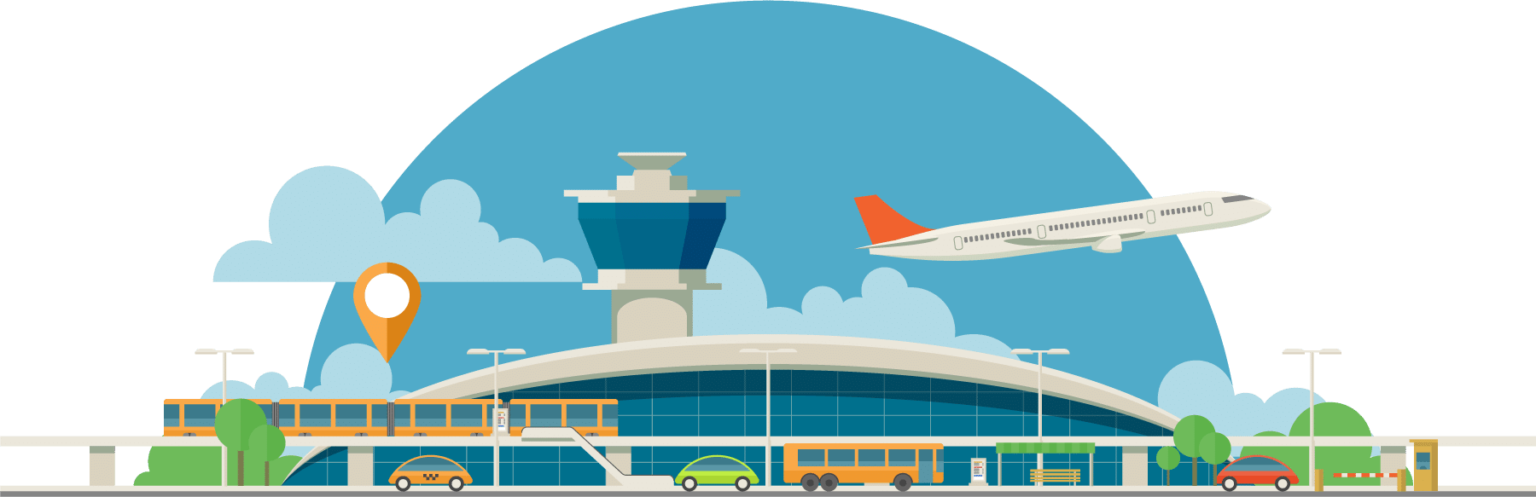

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b8c6bead079bf378edd3900df47f9cc8ab536075b6e20b4457744681ce0c4b59
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-05 18:28:26--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-05 18:28:27 (1.26 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

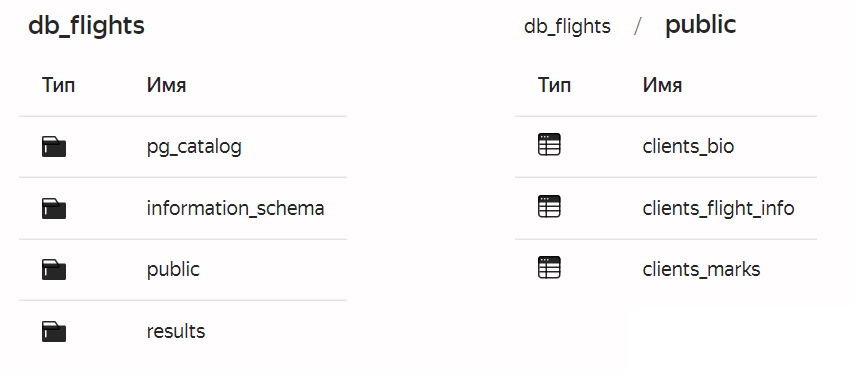



In [4]:
try:
    conn = psycopg2.connect(dbname='db_flights', user='mlhs_student', password='mlhs_student', host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net', port=6432, sslmode='verify-full', target_session_attrs='read-write')
except:
    print('Can`t establish connection to database')

In [5]:
conn.rollback()
with conn.cursor() as curs:
    curs.execute("SELECT column_name, data_type  FROM information_schema.columns WHERE table_name = 'clients_bio'")
    all = curs.fetchall()
    for items in all:
        print(items)

('id', 'integer')
('gender', 'text')
('age', 'text')


In [6]:
conn.rollback()
with conn.cursor() as curs:
    curs.execute("SELECT column_name, data_type  FROM information_schema.columns WHERE table_name = 'clients_flight_info'")
    all = curs.fetchall()
    for items in all:
        print(items)

('id', 'integer')
('Customer Type', 'text')
('Type of Travel', 'text')
('class', 'text')
('Flight Distance', 'text')
('Departure Delay in Minutes', 'text')
('Arrival Delay in Minutes', 'text')


In [7]:
conn.rollback()
with conn.cursor() as curs:
    curs.execute("SELECT column_name, data_type  FROM information_schema.columns WHERE table_name = 'clients_marks'")
    all = curs.fetchall()
    for items in all:
        print(items)

('id', 'integer')
('Inflight wifi service', 'text')
('Departure/Arrival time convenient', 'text')
('Ease of Online booking', 'text')
('Gate location', 'text')
('Food and drink', 'text')
('Online boarding', 'text')
('Seat comfort', 'text')
('Inflight entertainment', 'text')
('On-board service', 'text')
('Leg room service', 'text')
('Baggage handling', 'text')
('Checkin service', 'text')
('Inflight service', 'text')
('cleanliness', 'text')
('satisfaction', 'text')


In [5]:
query = """
SELECT
    cb.id,
    cb.gender,
    cb.age,
    cf."Customer Type",
    cf."Type of Travel",
    cf.class,
    cf."Flight Distance",
    cf."Departure Delay in Minutes",
    cf."Arrival Delay in Minutes",
    cm."Inflight wifi service",
    cm."Departure/Arrival time convenient",
    cm."Ease of Online booking",
    cm."Gate location",
    cm."Food and drink",
    cm."Online boarding",
    cm."Seat comfort",
    cm."Inflight entertainment",
    cm."On-board service",
    cm."Leg room service",
    cm."Baggage handling",
    cm."Checkin service",
    cm."Inflight service",
    cm."cleanliness",
    cm."satisfaction"
FROM clients_bio cb
JOIN clients_flight_info cf ON cb.id = cf.id
JOIN clients_marks cm ON cb.id = cm.id
"""

df = pd.read_sql(query, conn)
conn.close()
df.set_index('id', inplace=True)
df

<ipython-input-5-c635fac0a862>:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   
129868    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   

       Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                           
7               1963.0                        0.0                      0.0   
13               453.0                       16.0                     30.0   
18               821.0                        0.0                      0.0   
31               212.0                        0.0                      0.0   
39                67.0                        0.0                      0.0   
...                ...                        ...                      ...   
129838           308.0                       32.0                     24.0   
129839           337.0                        0.0                      0.0   
129846           447.0                        0.0                      0.0   
129868           447.0                        0.0                      0.0   
129876           447.0                        2.0                      3.0   

       Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                              ...   
7                        3.0                               3.0  ...   
13                       2.0                               2.0  ...   
18                       2.0                               5.0  ...   
31                       2.0                               2.0  ...   
39                       3.0                               3.0  ...   
...                      ...                               ...  ...   
129838                   3.0                               5.0  ...   
129839                   2.0                               4.0  ...   
129846                   2.0                               5.0  ...   
129868                   3.0                               4.0  ...   
129876                   4.0                               4.0  ...   

       Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                            
7                  4.0          5.0                    5.0              5.0   
13                 2.0          5.0                    5.0              2.0   
18                 1.0          5.0                    5.0              5.0   
31                 2.0          2.0                    2.0              4.0   
39                 5.0          4.0                    4.0              4.0   
...                ...          ...                    ...              ...   
129838             5.0          5.0                    3.0              3.0   
129839             2.0          3.0                    3.0              4.0   
129846             2.0          5.0                    5.0              4.0   
129868             3.0          4.0                    4.0              2.0   
129876             4.0          1.0                    4.0              5.0   

       Leg room service Baggage handling Checkin service Inflight service  \
id                                                   

In [6]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [7]:
columns_for_float = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Inflight wifi service',
                     'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink',
                     'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
                     'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness'
                     ]
df[columns_for_float] = df[columns_for_float].astype(float)

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

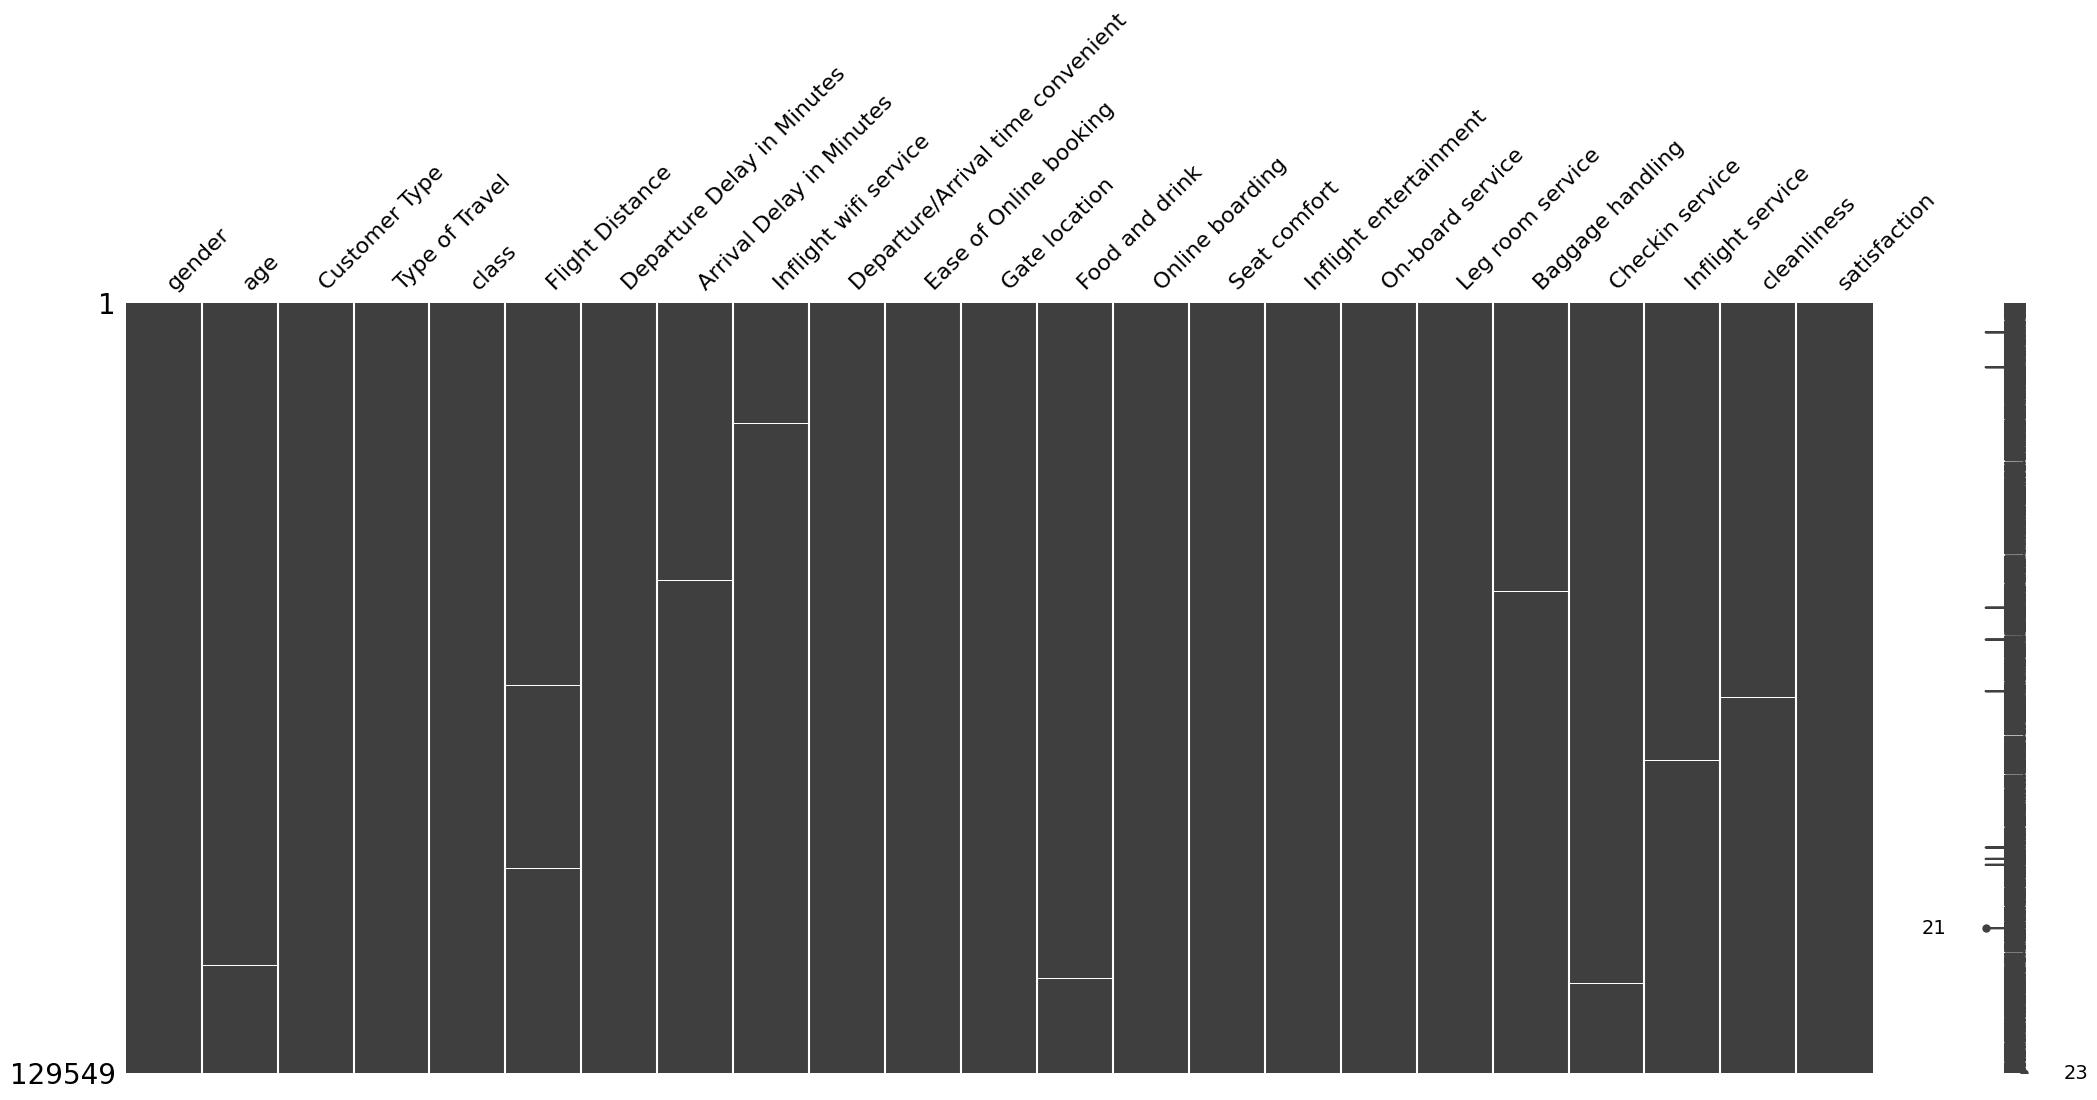

In [ ]:
missingno.matrix(df)
plt.show()

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


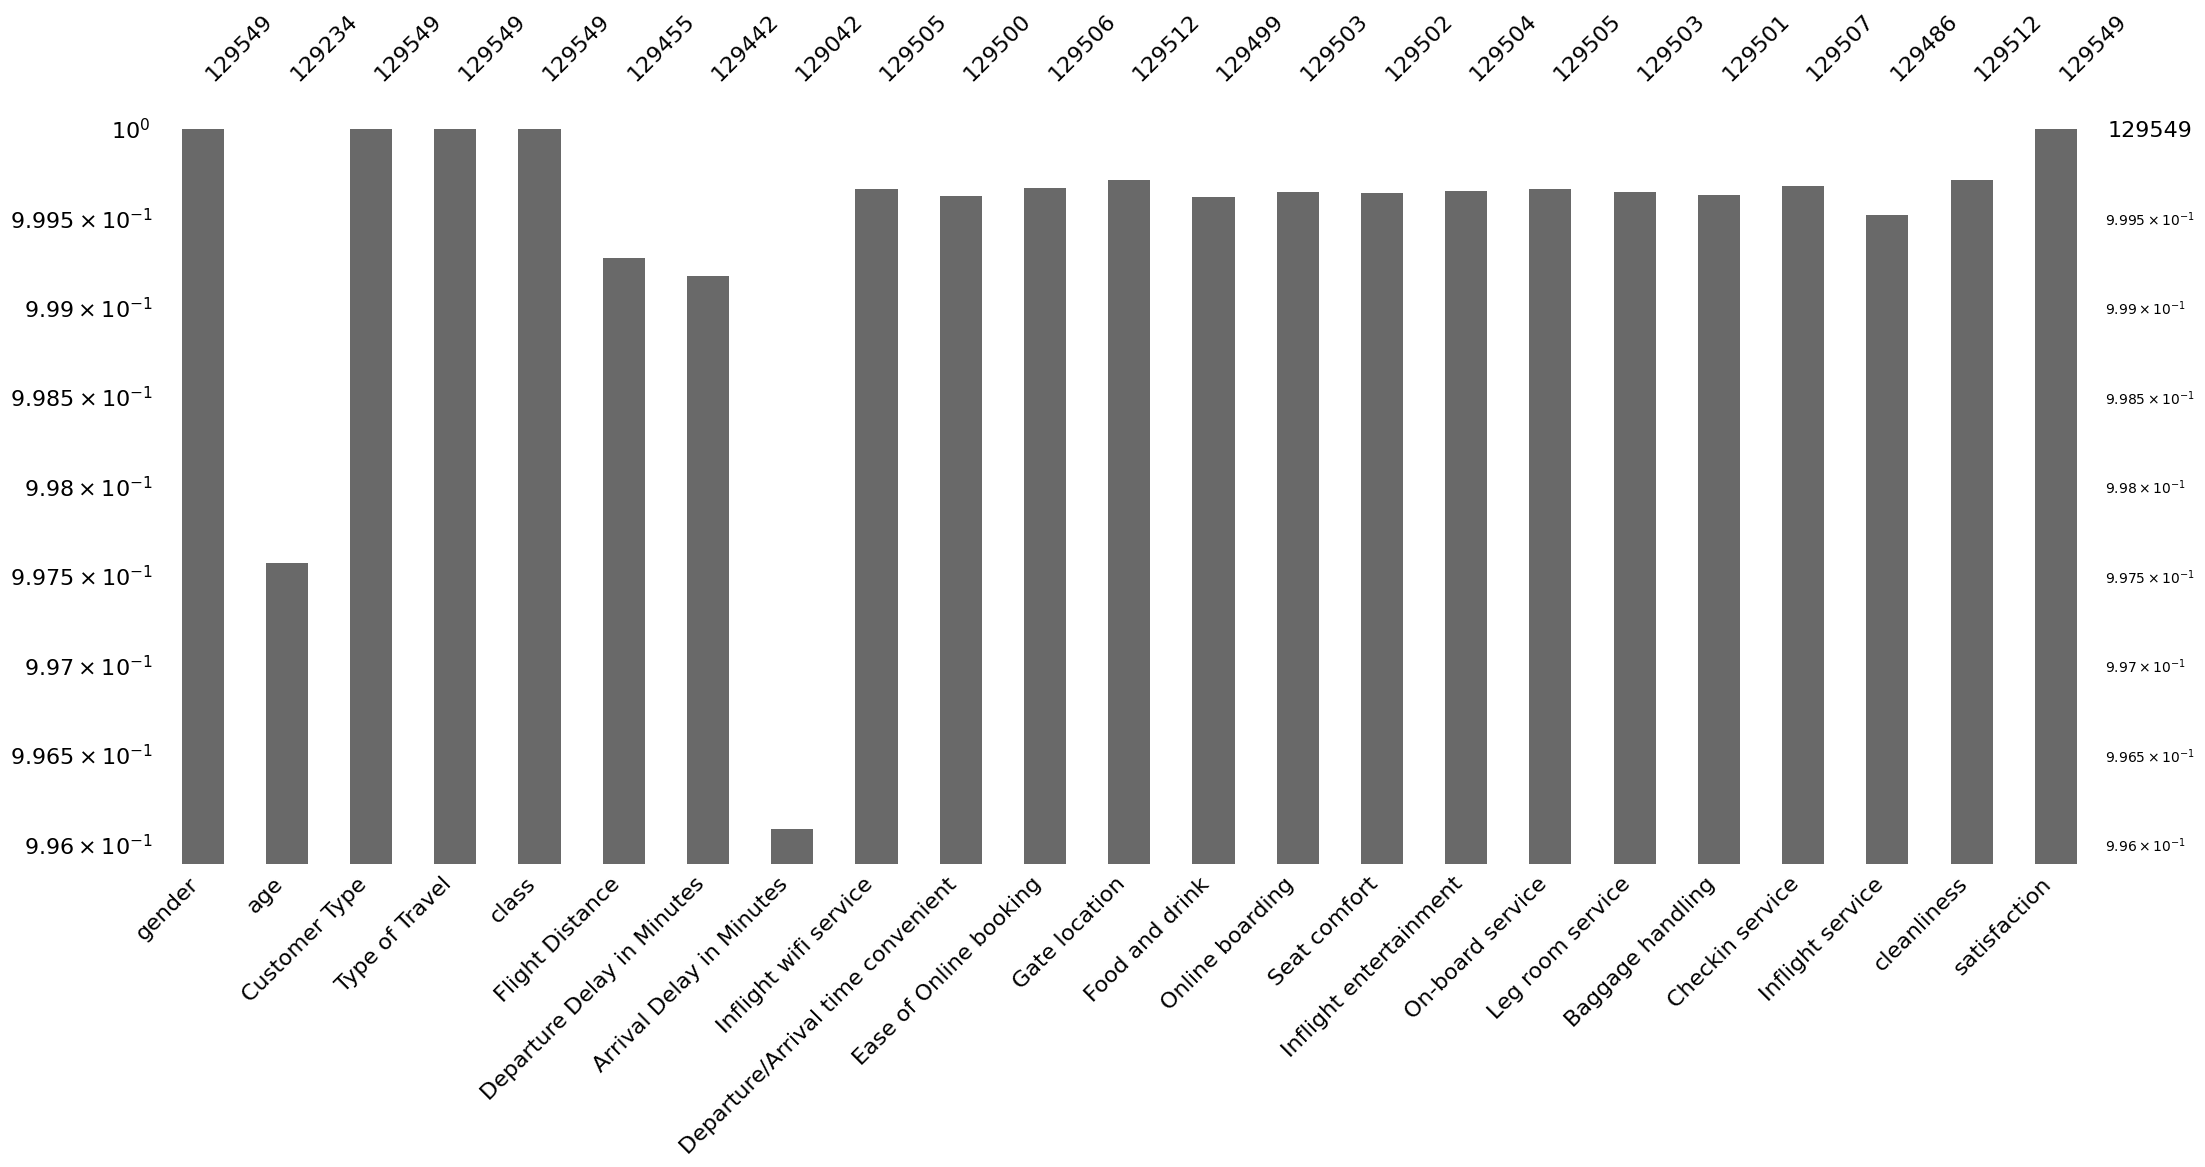

In [ ]:
missingno.bar(df, log=True)
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [8]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [9]:
assert df_train.shape == (103_644, 23)

In [10]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [11]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [13]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [14]:
X_train.replace("nan", None, inplace=True)
X_val.replace("nan", None, inplace=True)
df_test.replace("nan", None, inplace=True)

In [ ]:
X_train.isna().sum()

gender                                 0
age                                  185
Customer Type                         52
Type of Travel                        70
class                                 66
Flight Distance                       54
Departure Delay in Minutes            61
Arrival Delay in Minutes             294
Inflight wifi service                 23
Departure/Arrival time convenient     28
Ease of Online booking                24
Gate location                         19
Food and drink                        22
Online boarding                       23
Seat comfort                          23
Inflight entertainment                30
On-board service                      23
Leg room service                      22
Baggage handling                      21
Checkin service                       22
Inflight service                      30
cleanliness                           21
dtype: int64

In [15]:
for col in X_train.columns:
  moda = X_train[col].mode()[0]
  if X_train[col].isna().any():
    X_train[col].fillna(moda, inplace=True)

<ipython-input-15-507b57f2609e>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(moda, inplace=True)


In [ ]:
X_val.isna().sum()

gender                                 0
age                                   76
Customer Type                         14
Type of Travel                        18
class                                 23
Flight Distance                       18
Departure Delay in Minutes            23
Arrival Delay in Minutes             111
Inflight wifi service                  9
Departure/Arrival time convenient     13
Ease of Online booking                 9
Gate location                         11
Food and drink                        13
Online boarding                       14
Seat comfort                          18
Inflight entertainment                12
On-board service                       9
Leg room service                      14
Baggage handling                      11
Checkin service                       12
Inflight service                      19
cleanliness                           10
dtype: int64

In [16]:
for col in X_val.columns:
  moda = X_train[col].mode()[0]
  if X_val[col].isna().any():
    X_val[col].fillna(moda, inplace=True)

<ipython-input-16-6e2a1ba452a8>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val[col].fillna(moda, inplace=True)


In [17]:
for col in df_test.columns:
  moda = df_test[col].mode()[0]
  if df_test[col].isna().any():
    df_test[col].fillna(moda, inplace=True)

<ipython-input-17-a5e65677429c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col].fillna(moda, inplace=True)


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [ ]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [ ]:
X_val.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  31094.000000     31094.000000                31094.000000   
mean      39.955779      1316.469480                   15.666945   
std       19.549492      4379.003672                   80.658377   
min        0.000000         0.000000                    0.000000   
25%       27.000000       417.000000                    0.000000   
50%       40.000000       845.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      612.000000    255522.000000                11011.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              31094.000000           31094.000000   
mean                  16.871776               2.732521   
std                  131.103562               1.348038   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              40.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       31094.000000            31094.000000   
mean                            3.064836                2.758989   
std                             1.558570                1.439010   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            35.000000               45.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   31094.000000    31094.000000     31094.000000  31094.000000   
mean        2.978195        3.195215         3.252589      3.438477   
std         1.290490        1.358929         1.414625      1.356474   
min         1.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        32.000000       45.000000        40.000000     36.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            31094.000000      31094.000000      31094.000000   
mean                 3.359265          3.394578          3.367756   
std                  1.358533          1.337013          1.379536   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 36.000000         40.000000         40.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      31094.000000     31094.000000      31094.000000  31094.000000  
mean           3.648775         3.306908          3.655303      3.286776  
std            1.224217         1.321872          1.204409      1.345356  
min            1.000000         0.000000          1.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         35.000000     40.000000

In [ ]:
X_train.describe(include='object')

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

In [ ]:
X_val.describe(include='object')

gender   Customer Type   Type of Travel     class
count    31094           31094            31094     31094
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     15774           25315            21457     14783

1. В данных есть выбросы(максимальный возраст 500+ и дистанция 370+к километров пока для нас нереальные цифры)
2. Какие-то признаки от 0 до 40, другие до 300к+, в таком разбросе неплохо бы масштабировать данные.
3. Категориальные столбцы удобно будет закондировать one hot энкодером, тк там от 2 до 4 категорий.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [18]:
for col in X_train.select_dtypes(include='float').columns:
  threshold = X_train[col].quantile(0.996)
  X_train = X_train[X_train[col] <= threshold]

In [19]:
for col in X_val.select_dtypes(include='float').columns:
  threshold = X_val[col].quantile(0.996)
  X_val = X_val[X_val[col] <= threshold]

In [20]:
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

In [21]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71175, 22), (71175,), (30498, 22), (30498,))

In [22]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [ ]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      sns.countplot(x=df[col], hue=y)
      plt.title(f'Распределение оценки {col}')
      plt.xlabel('Оценка пассажира')
      plt.ylabel('Количество оценок')
      plt.show()
    pass


In [ ]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    plt.figure(figsize=(12, 5 * len(cols)))

    for i, col in enumerate(cols):
        plt.subplot(len(cols), 2, 2 * i + 1)
        sns.kdeplot(data=df, x=col, hue=y, fill=True)
        plt.title(f"KDE Plot: {col}")

        plt.subplot(len(cols), 2, 2 * i + 2)
        sns.boxplot(data=df, x=col, y=y)
        plt.title(f"Box Plot: {col}")

    plt.tight_layout()
    plt.show()
    pass

In [ ]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      sns.countplot(x=df[col], hue=y)
      plt.title(f'Распределение {col}')
    #  plt.xlabel('Оценка пассажира')
    #  plt.ylabel('Количество оценок')
      plt.show()
    pass

Отрисовка.

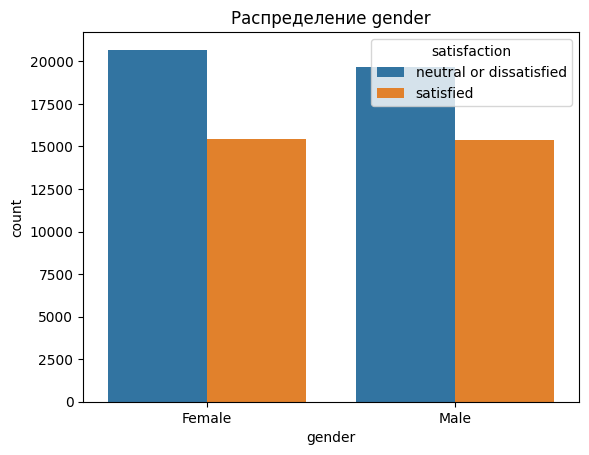

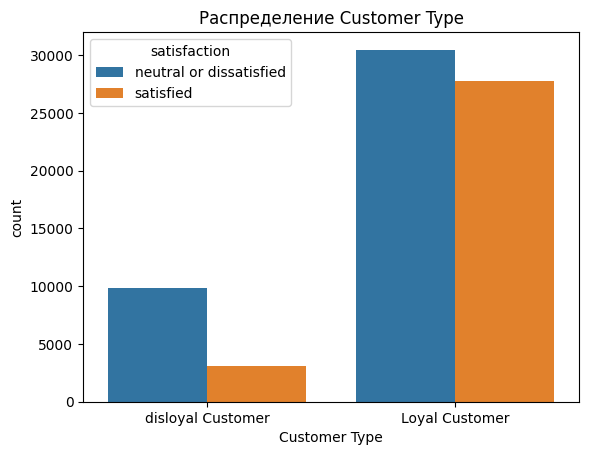

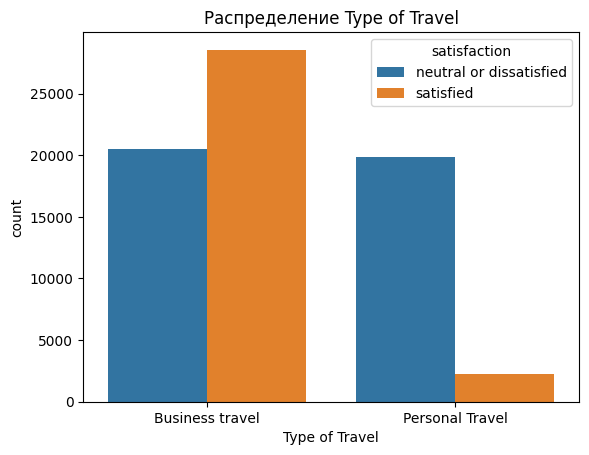

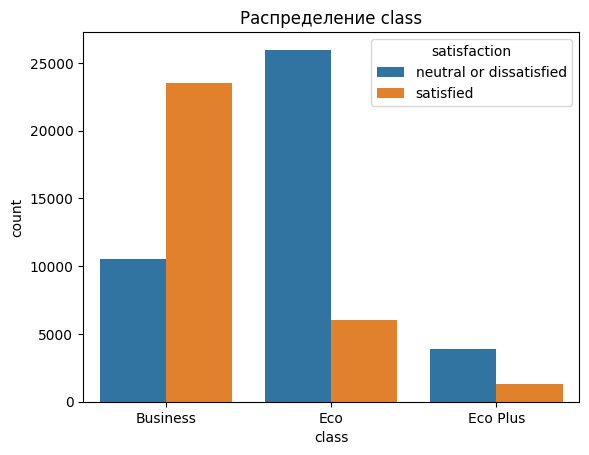

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

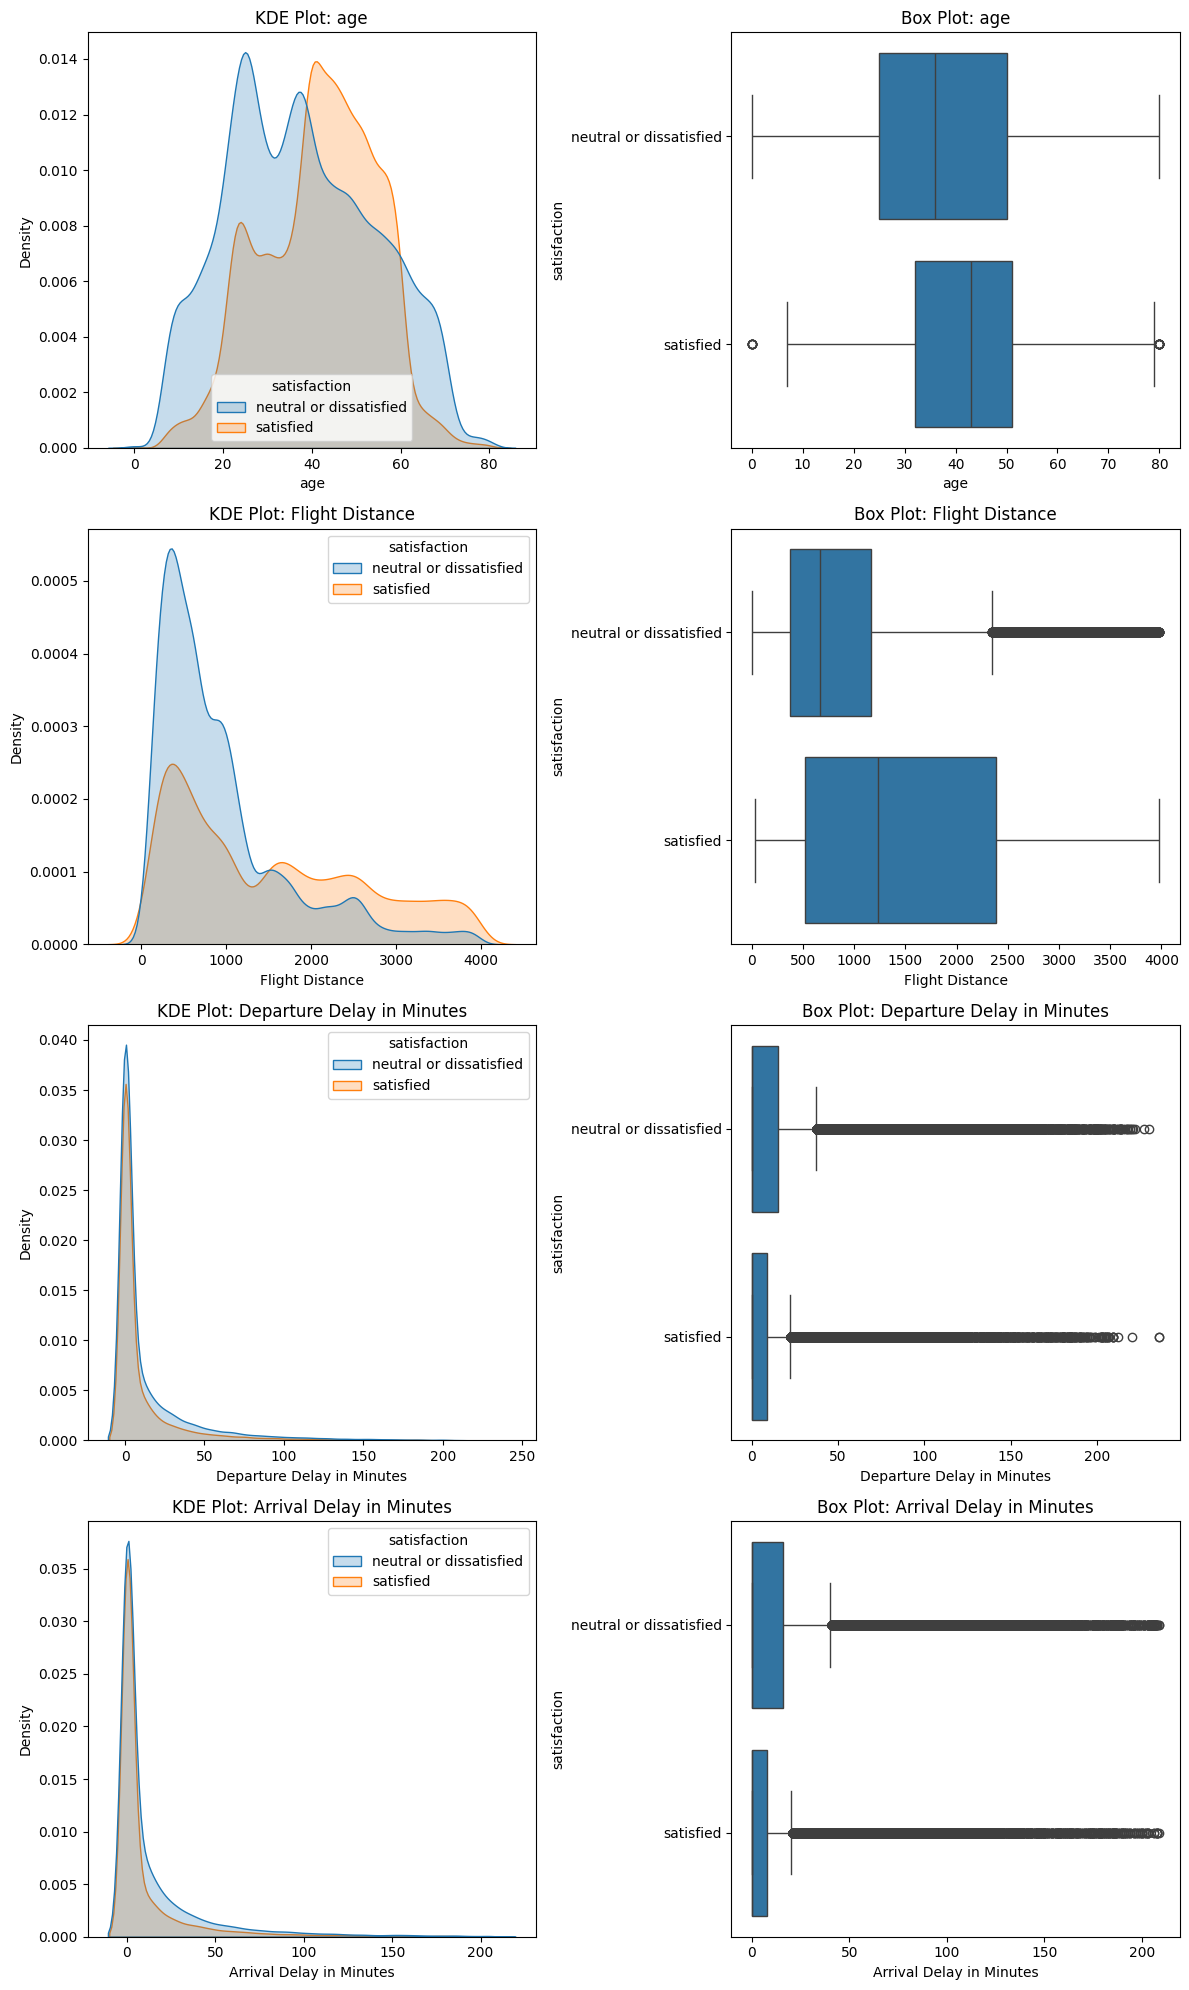

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

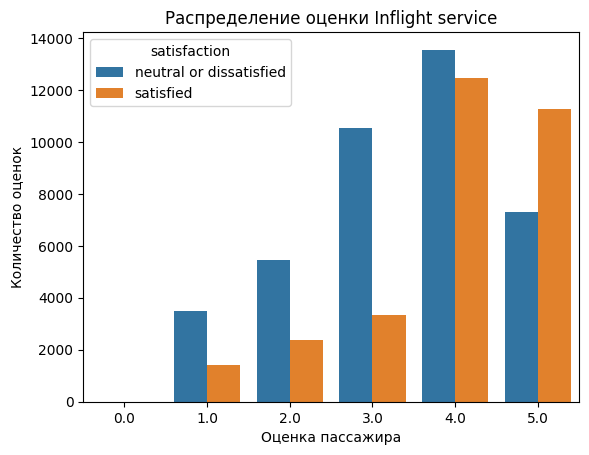

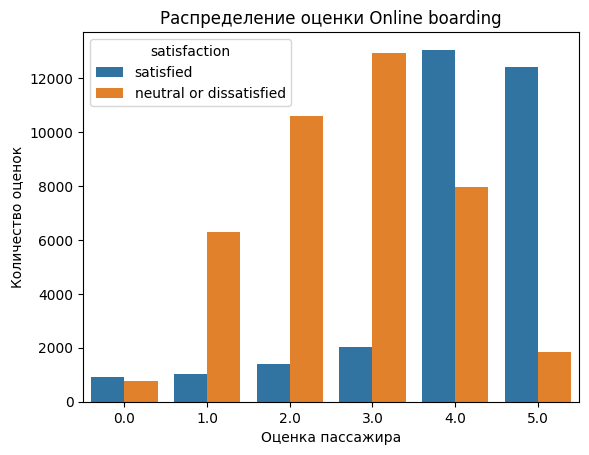

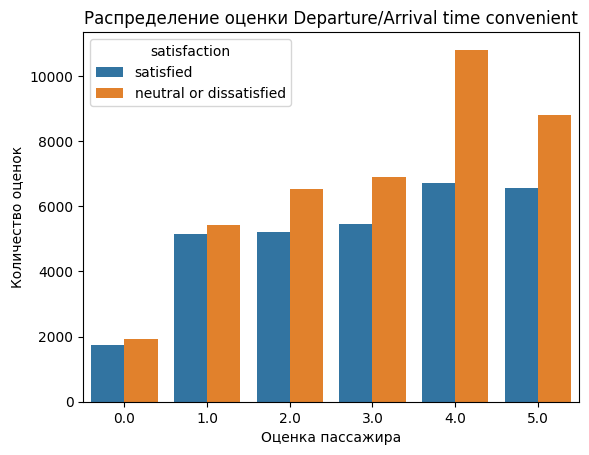

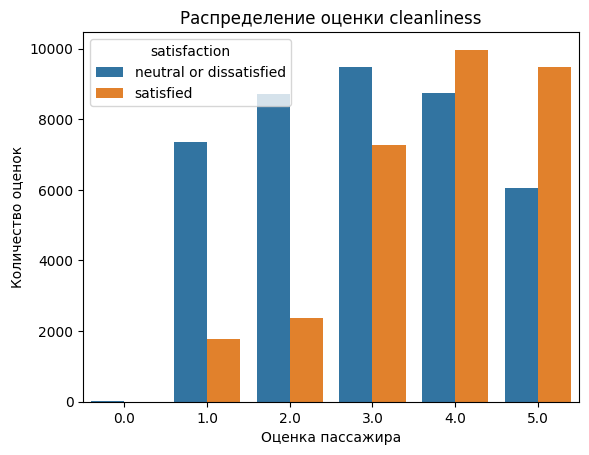

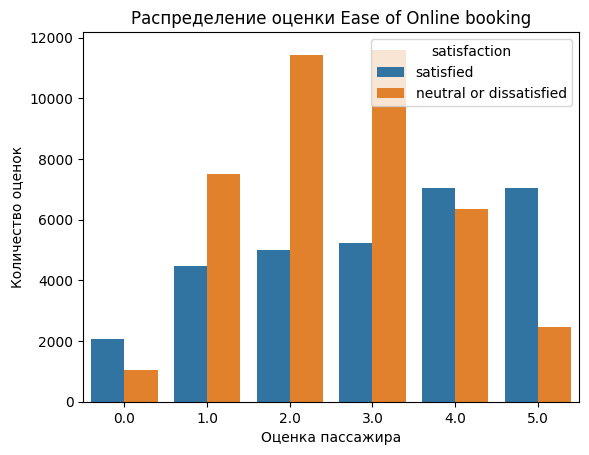

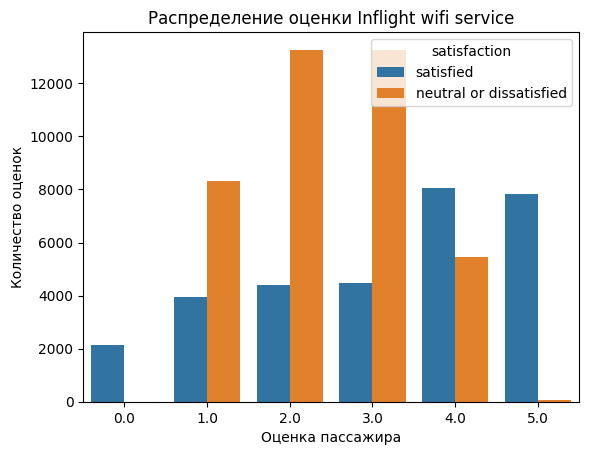

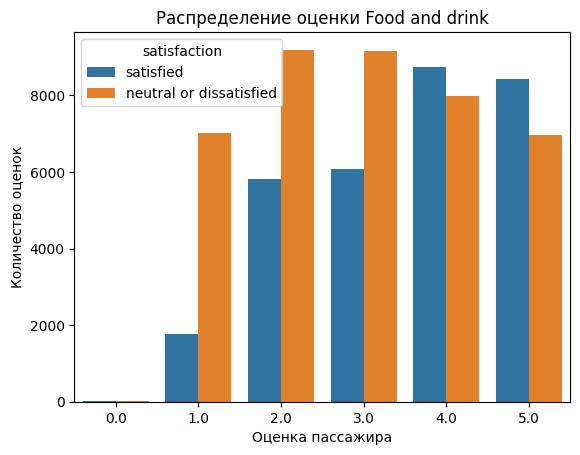

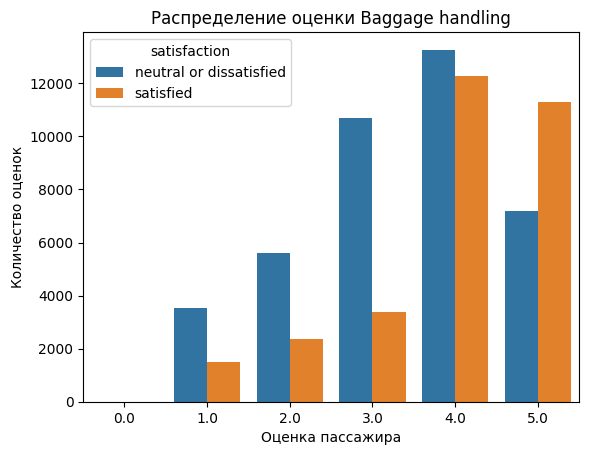

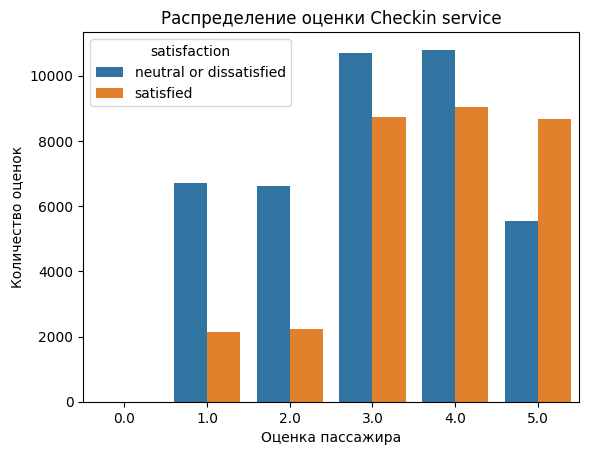

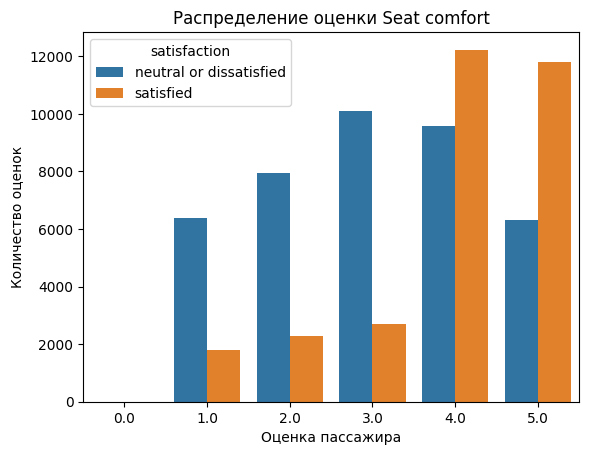

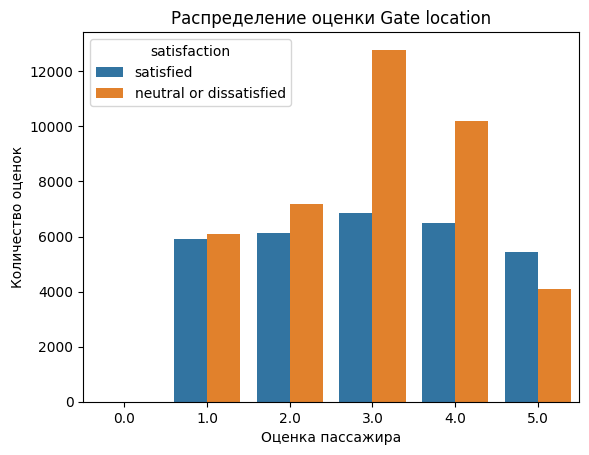

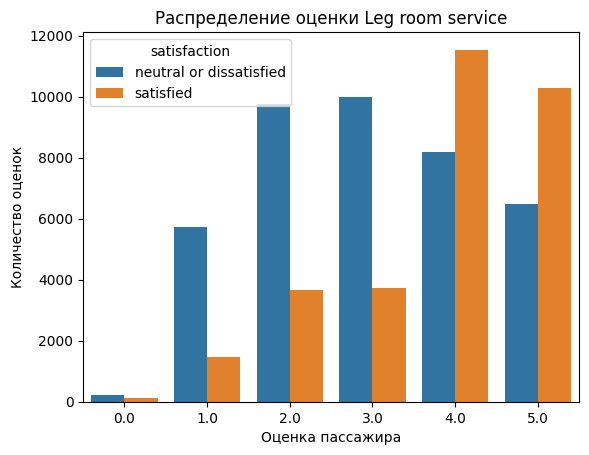

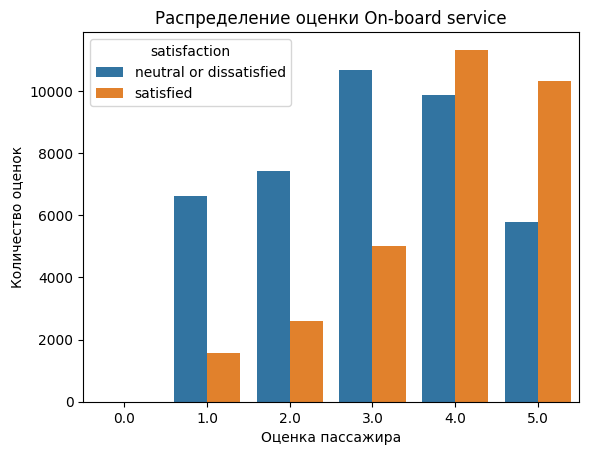

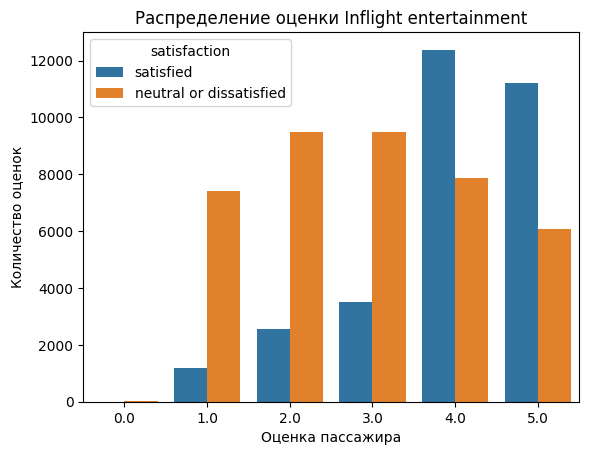

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

<ipython-input-44-6cb6bf3946a2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis")


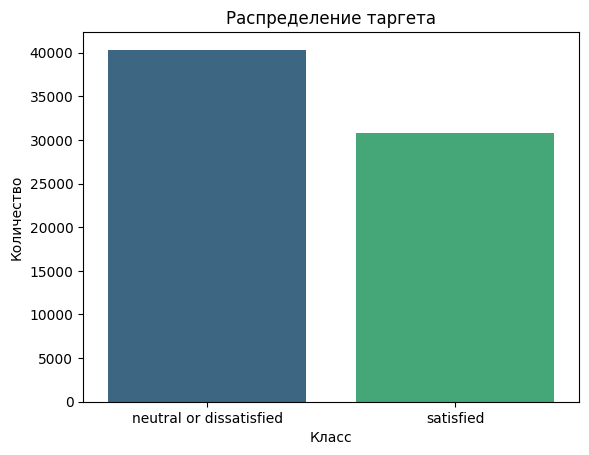

In [ ]:
sns.countplot(x=y_train, palette="viridis")
plt.title("Распределение таргета")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
1. Неравномерно распределены: участие в лояльной программе(участников программы намного больше), класс, которым летит человек(пассажиров бизнес класса и эконома больше чем эко+ и они естественно поставили больше хороших оценок), и тип поездки( бизнесс полетов сильно больше)
2. Классы не сбалансированы, нейтральных или неудовлетворительных оценок больше
3. Задержка отправки и прибытия имеют экспоненциальное распределение(большинство значений равно или около 0). Дистанция похоже на лог-нормальное растпределение(особенно среди удовлетворенных пассажиров), а возраст на нормальное.
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [ ]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [23]:
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes'])

Построение.

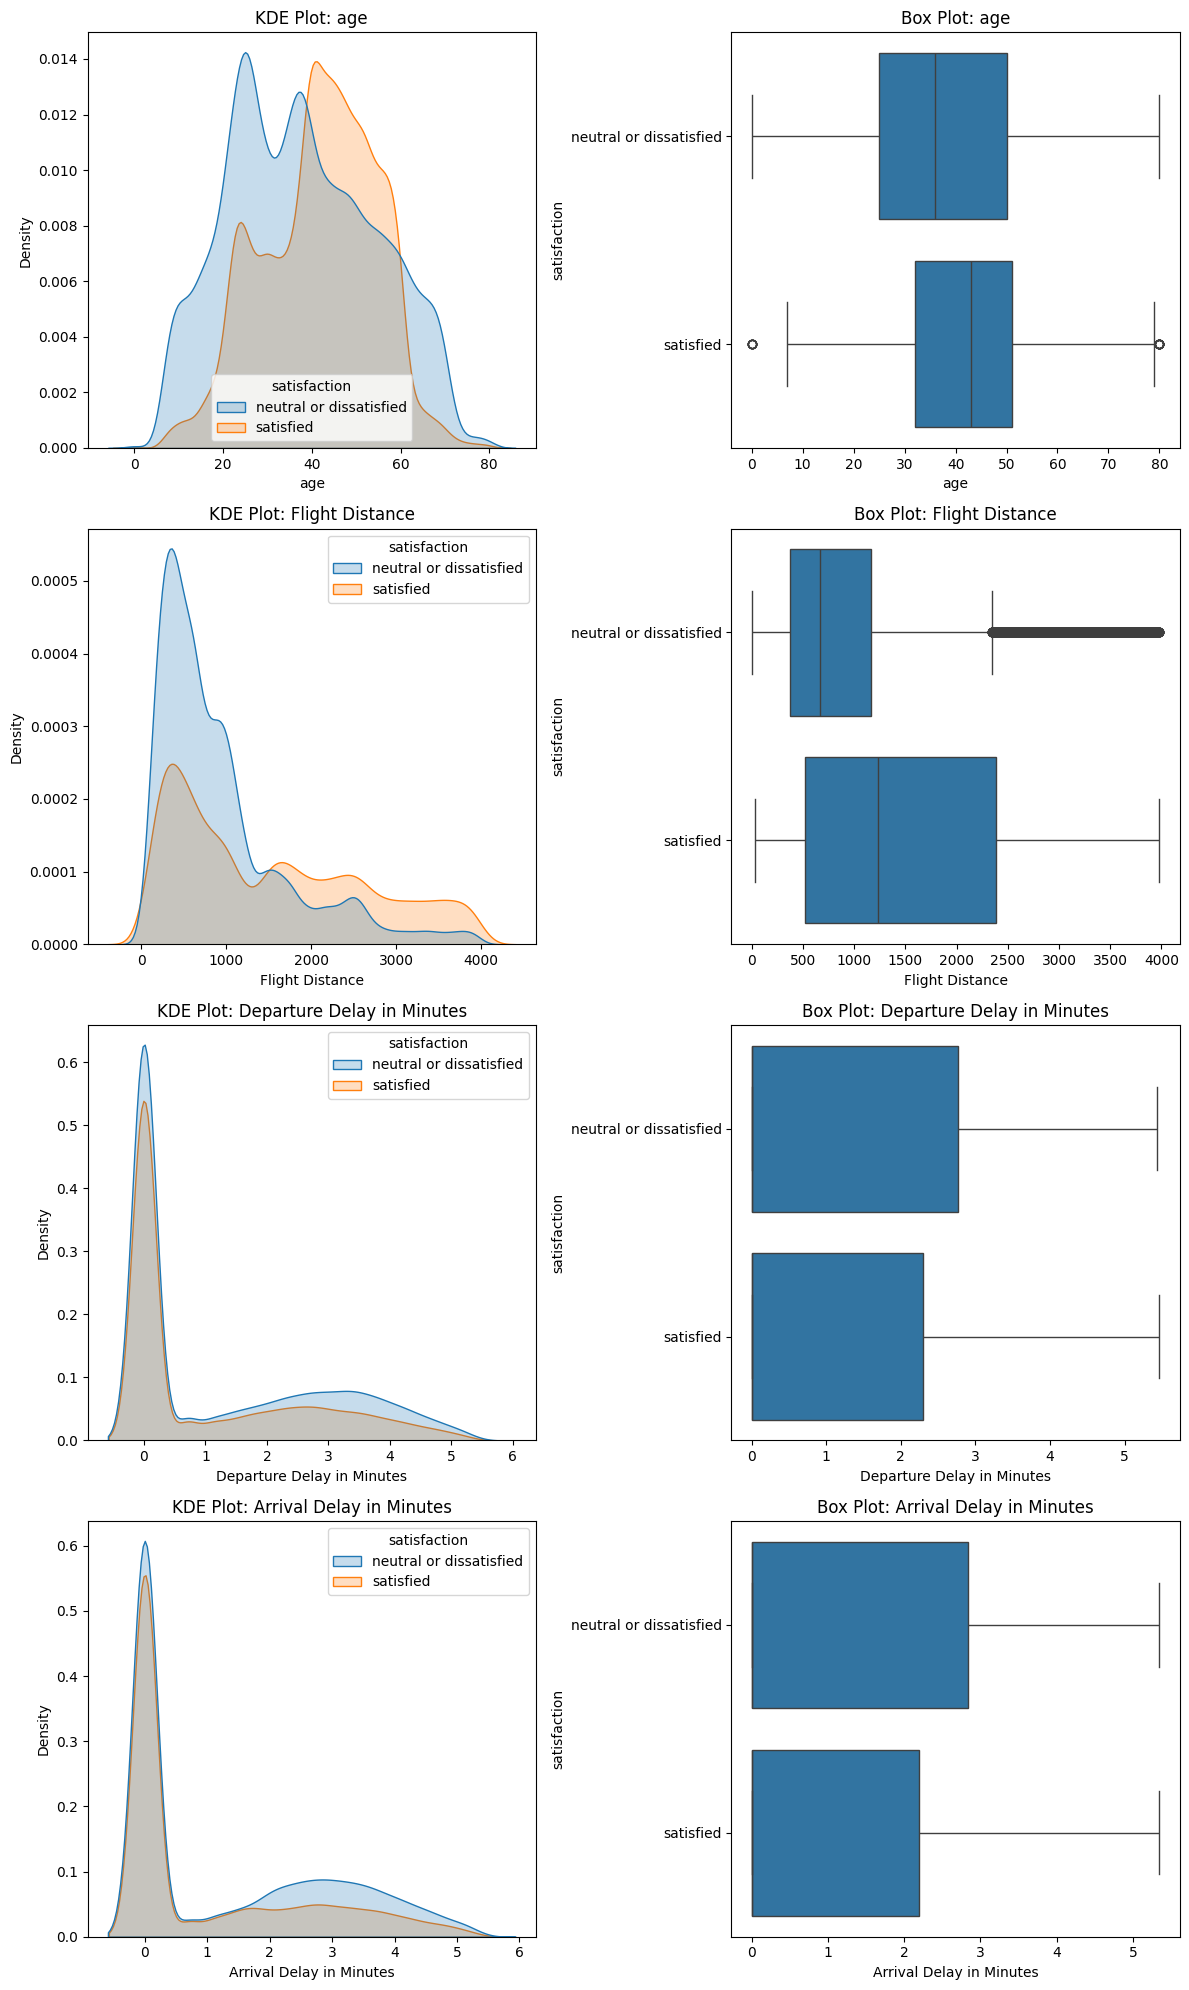

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

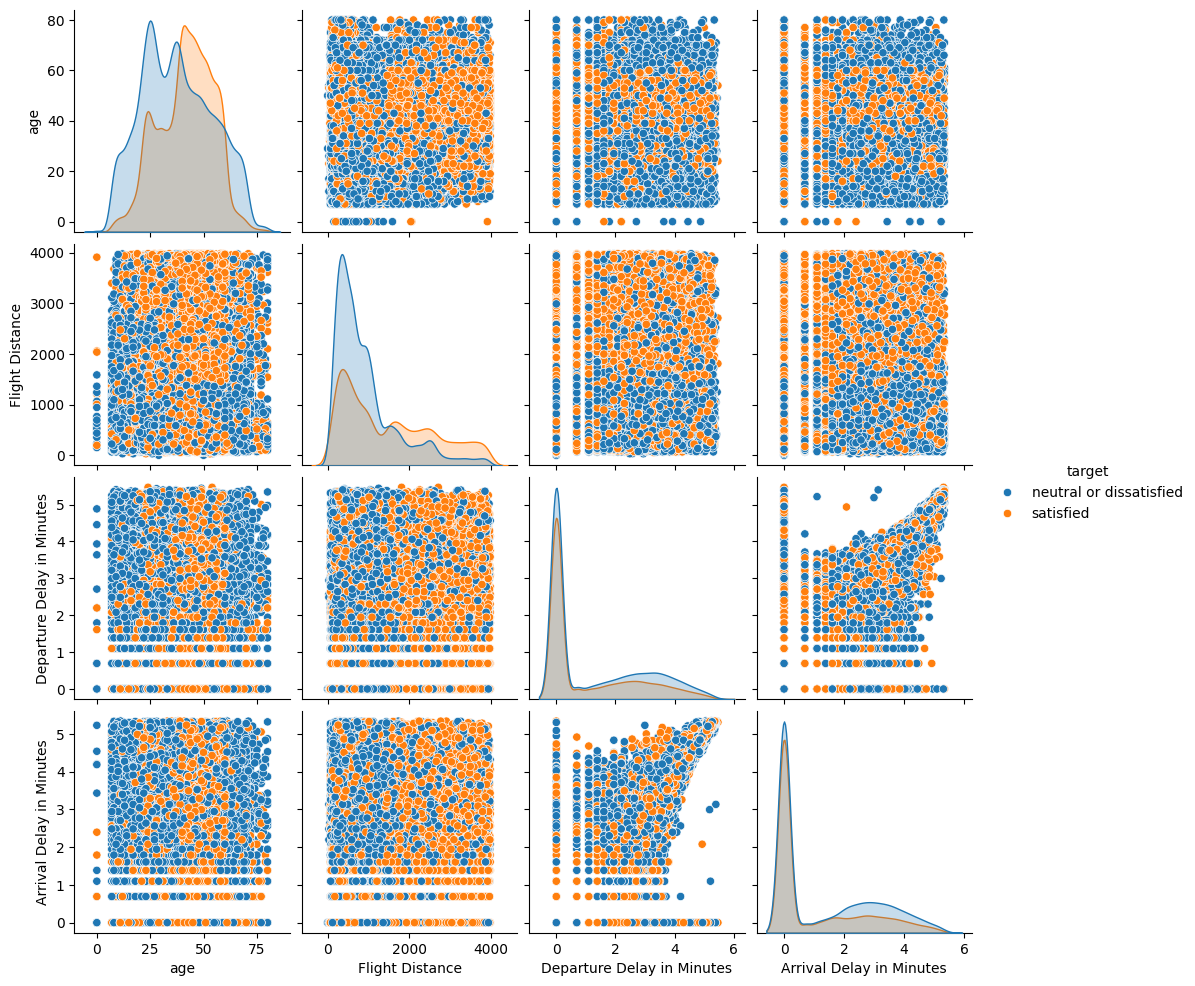

In [ ]:
X_train_target = X_train[continuous_cols].copy()
X_train_target['target'] = y_train
sns.pairplot(X_train_target, hue='target')
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [24]:
y_train = np.where(y_train == 'satisfied', 1, 0)
y_val = np.where(y_val == 'satisfied', 1, 0)

In [40]:
col_for_ohe = ['gender', 'Customer Type', 'Type of Travel', 'class']

X_train_enc = pd.get_dummies(X_train, columns=col_for_ohe, dtype=float)
X_val_enc = pd.get_dummies(X_val, columns=col_for_ohe, dtype=float)

In [ ]:
X_train_enc

age  Flight Distance  Departure Delay in Minutes  \
id                                                          
2031    29.0            785.0                    0.000000   
11597   45.0           3269.0                    0.000000   
74668    8.0           1431.0                    0.000000   
31602   48.0            602.0                    0.000000   
51518   25.0            651.0                    0.000000   
...      ...              ...                         ...   
63360   25.0            337.0                    0.000000   
29678   77.0           1448.0                    0.000000   
118743  31.0            304.0                    3.091042   
8922    45.0            661.0                    0.000000   
28513   55.0           1359.0                    0.000000   

        Arrival Delay in Minutes  Inflight wifi service  \
id                                                        
2031                    0.000000                    2.0   
11597                   0.000000                    0.0   
74668                   0.000000                    3.0   
31602                   0.000000                    4.0   
51518                   0.000000                    5.0   
...                          ...                    ...   
63360                   0.000000                    1.0   
29678                   0.000000                    2.0   
118743                  2.564949                    4.0   
8922                    0.000000                    4.0   
28513                   0.000000                    3.0   

        Departure/Arrival time convenient  Ease of Online booking  \
id                                                                  
2031                                  2.0                     2.0   
11597                                 0.0                     0.0   
74668                                 1.0                     3.0   
31602                                 5.0                     4.0   
51518                                 0.0                     5.0   
...                                   ...                     ...   
63360                                 4.0                     1.0   
29678                                 5.0                     5.0   
118743                                4.0                     4.0   
8922                                  1.0                     4.0   
28513                                 3.0                     3.0   

        Gate location  Food and drink  Online boarding  ...  cleanliness  \
id                                                      ...                
2031              4.0             4.0              2.0  ...          4.0   
11597             3.0             2.0              2.0  ...          1.0   
74668             2.0             5.0              3.0  ...          5.0   
31602             3.0             2.0              5.0  ...          3.0   
51518             2.0             2.0              5.0  ...          2.0   
...               ...             ...              ...  ...          ...   
63360             4.0             4.0              1.0  ...          4.0   
29678             5.0             2.0              2.0  ...          2.0   
118743            1.0             1.0              4.0  ...          1.0   
8922              4.0             2.0              4.0  ...          2.0   
28513             3.0             3.0              3.0  ...          3.0   

        gender_Female  gender_Male  Customer Type_Loyal Customer  \
id                                                                 
2031              1.0          0.0                           0.0   
11597             1.0          0.0                           1.0   
74668             0.0          1.0                           1.0   
31602             1.0          0.0                           1.0   
51518             1.0          0.0                           0.0   
...               ...          ...                           ...   
63360           

In [26]:
len(y_train)

71175

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [41]:
model = DecisionTreeClassifier()
model.fit(X_train_enc, y_train)
y_pred = model.predict(X_val_enc)
acc = accuracy_score(y_pred, y_val)
acc

0.9446193192996262

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp(model, X_train_enc.to_numpy(), y_train, X_val_enc.to_numpy(), y_val,
    loss='0-1_loss', num_rounds=50, random_seed=5)
error_dt, bias_dt, var_dt

(0.059366515837104075, 0.039937045052134565, 0.04356351236146632)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
depth = model.get_depth()
leaves = model.get_n_leaves()
print(f'Глубина: {depth}, количество листьев: {leaves}')

Глубина: 30, количество листьев: 1961


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

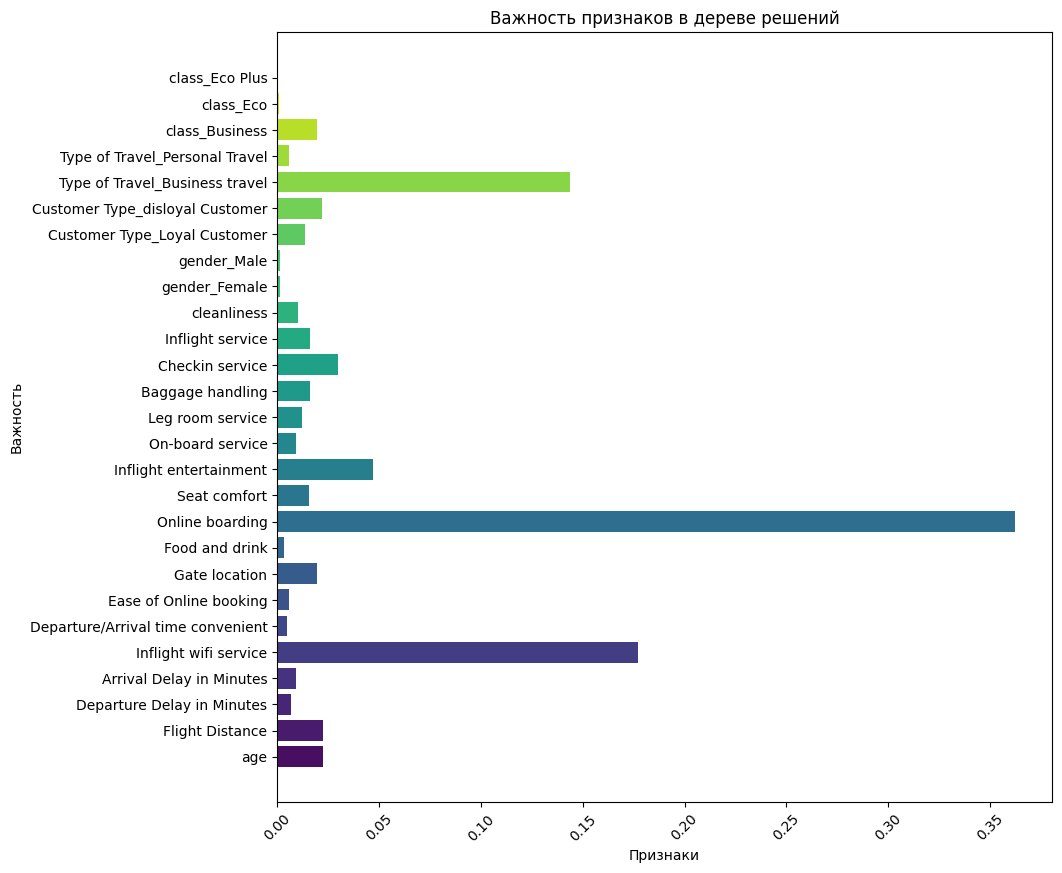

In [42]:
feature_impotant_tree = model.feature_importances_
features = X_train_enc.columns

colormap_colors = sns.color_palette("viridis", len(features))

plt.figure(figsize=(10, 10))
plt.barh(features, feature_impotant_tree, color=colormap_colors)
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.title("Важность признаков в дереве решений")
plt.xticks(rotation=45)
plt.show()

Наиболее информативные это онлайн посадочный талон, wi-fi в самолете и тип поездки - бизнес.

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [43]:
feature_impotant_tree

array([0.02249453, 0.02241762, 0.0065785 , 0.00922212, 0.17721115,
       0.00503809, 0.00559836, 0.01947551, 0.00340127, 0.36238478,
       0.01557293, 0.04723655, 0.00907472, 0.01244295, 0.01616528,
       0.02998476, 0.01593592, 0.01047507, 0.00143632, 0.0012207 ,
       0.0136461 , 0.02178666, 0.14373357, 0.00601402, 0.0197556 ,
       0.00108933, 0.00060759])

In [44]:
np.argsort(feature_impotant_tree)[-2:]

array([4, 9])

In [45]:
top_2 = np.argsort(feature_impotant_tree)[-2:]
top_2_features = X_train_enc.iloc[:, top_2]

In [47]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(top_2_features, y_train)

DecisionTreeClassifier(max_depth=5)

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

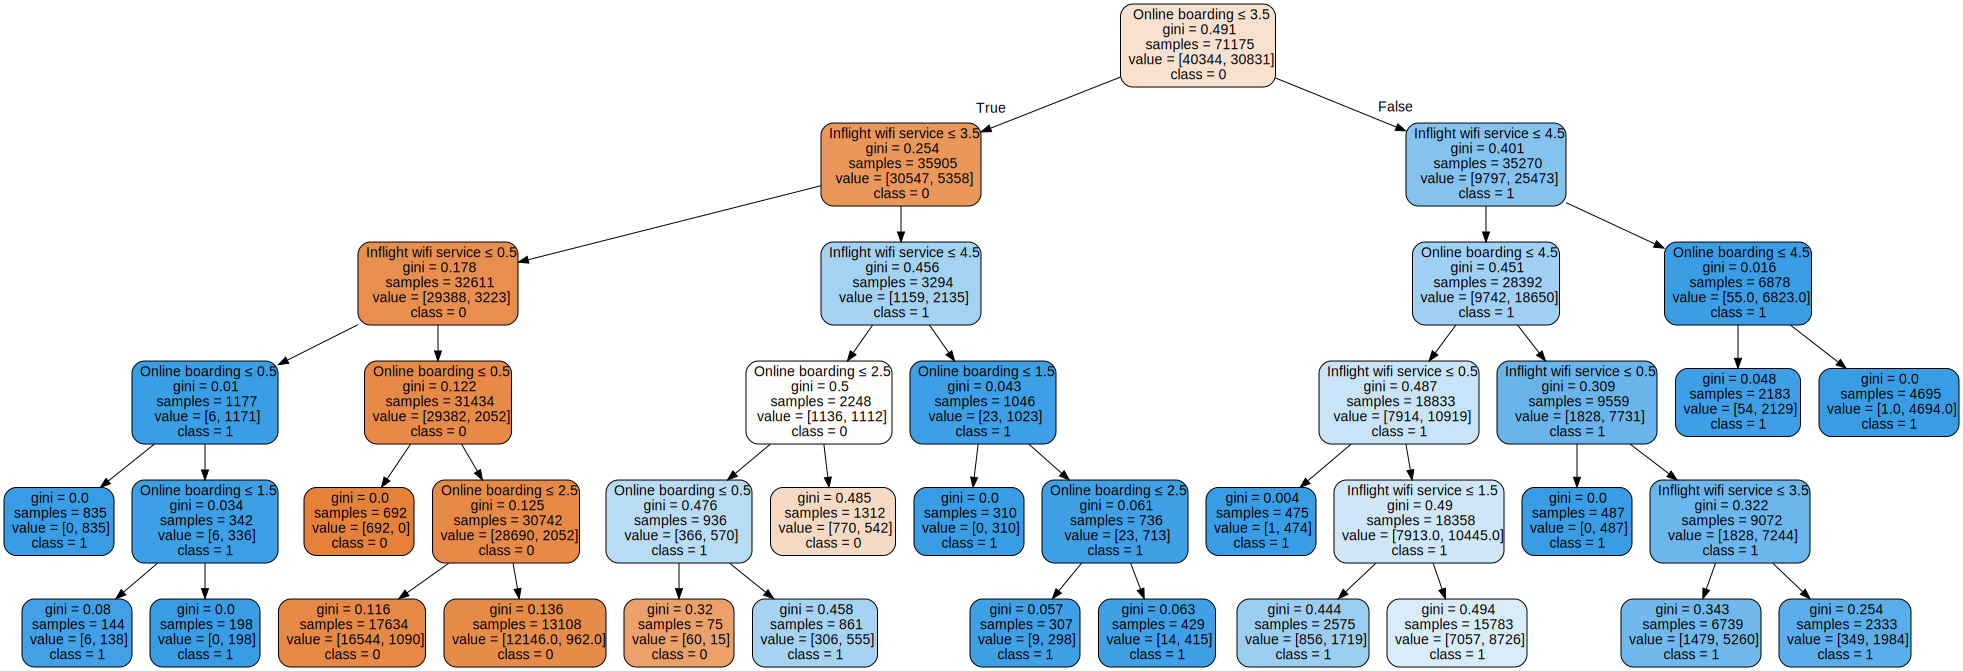

In [ ]:
feature_names = X_train_enc.columns[top_2] if hasattr(X_train_enc, "columns") else [f"Feature {i}" for i in top_2]

dot_data = export_graphviz(tree,
                           feature_names=feature_names,
                           class_names=["0", "1"],
                           filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph

`Потому что используется среднее значения между соседними значениями для порога разбиения, а у нас 2 лучшие фичи это целые оценки от 0 до 5, поэтому среднее между 1 и 2, 2 и 3 и тд. будет кратно 0.5 `


### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

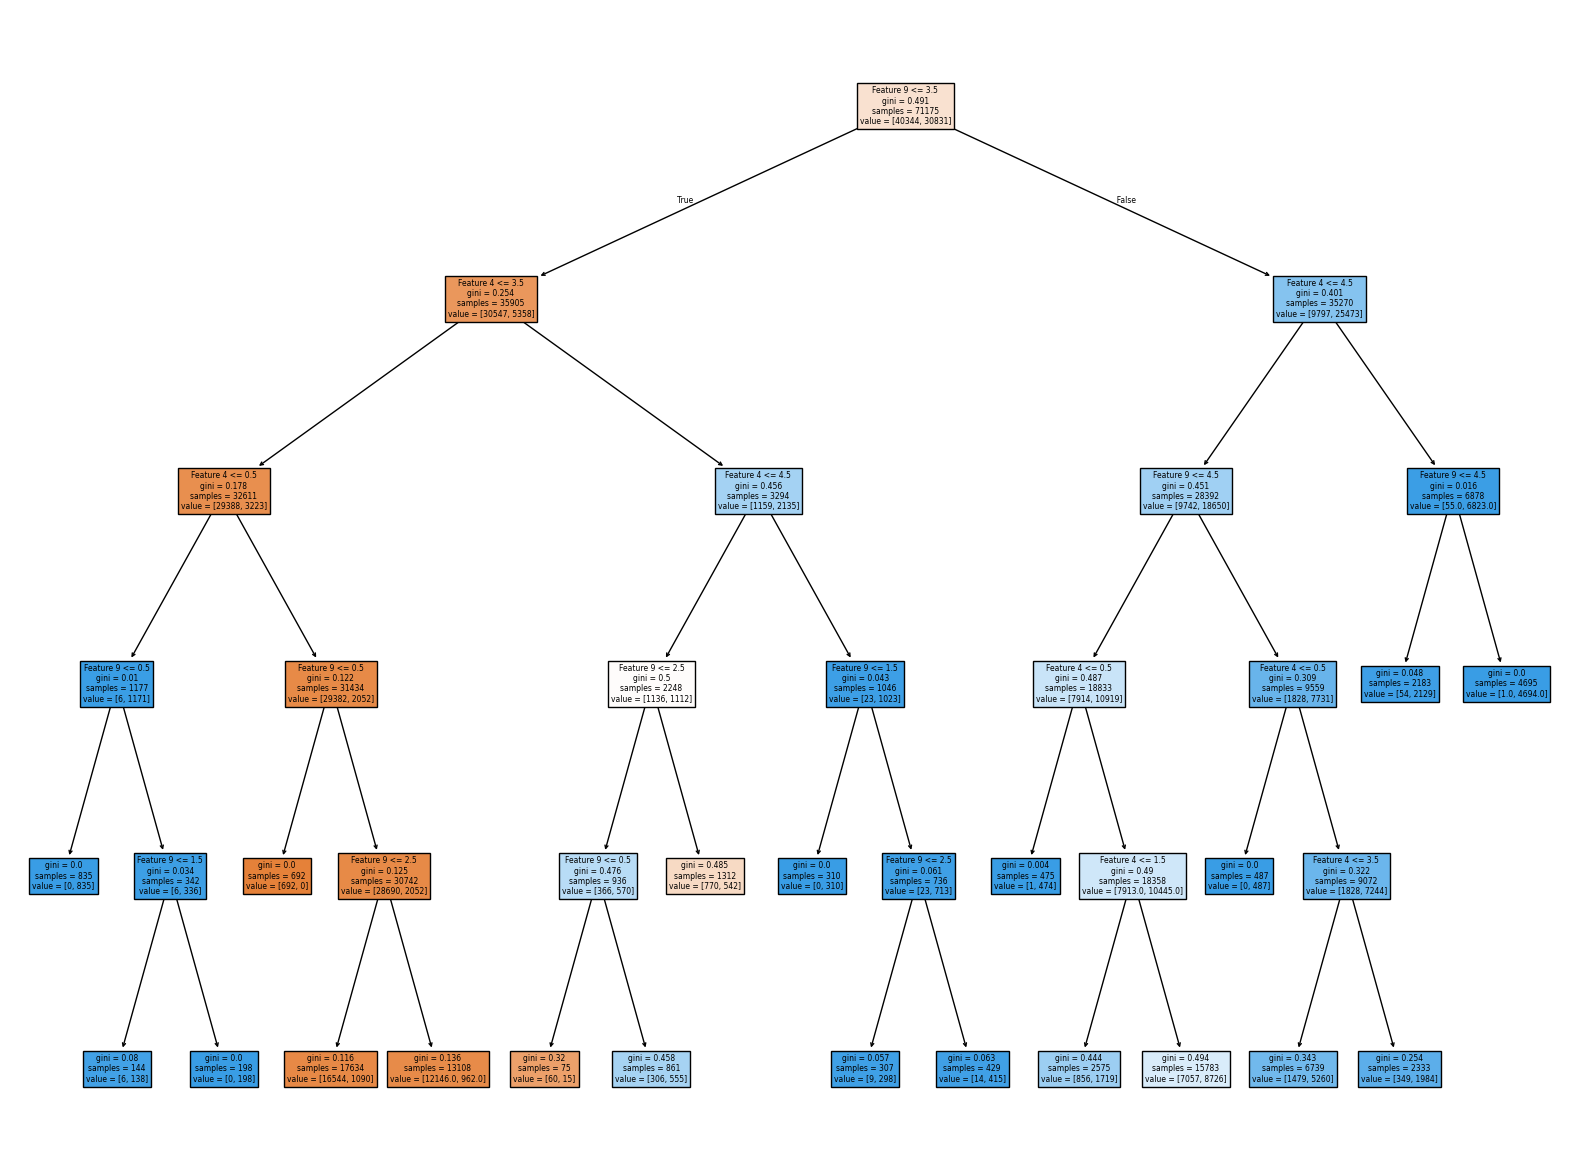

In [ ]:
plt.figure(figsize=(20, 15))
plot_tree(tree, feature_names=[f"Feature {i}" for i in top_2], filled=True)
plt.show()

Дерево нессиметричное, но для нашего случая это норма, тк все же признак - Online boardig сильно преобладает в значимости чем наличие вай фая, и сами классы несбалансированы.

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


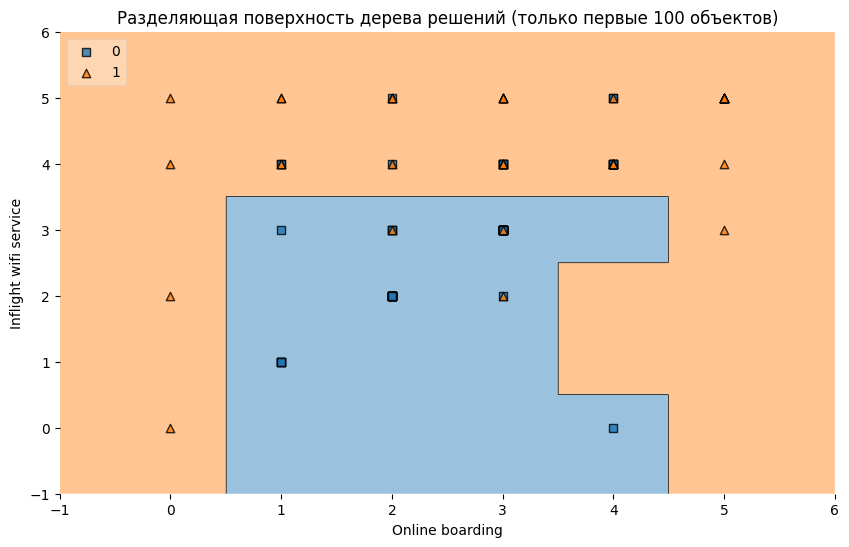

In [48]:
x_train_100 = top_2_features.iloc[:100].values
y_train_100 = y_train[:100]

plt.figure(figsize=(10, 6))
plot_decision_regions(x_train_100, y_train_100, clf=tree, legend=2)
plt.xlabel("Online boarding")
plt.ylabel("Inflight wifi service")
plt.title("Разделяющая поверхность дерева решений (только первые 100 объектов)")
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [51]:
top_2_features.shape, y_train.shape

((71175, 2), (71175,))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

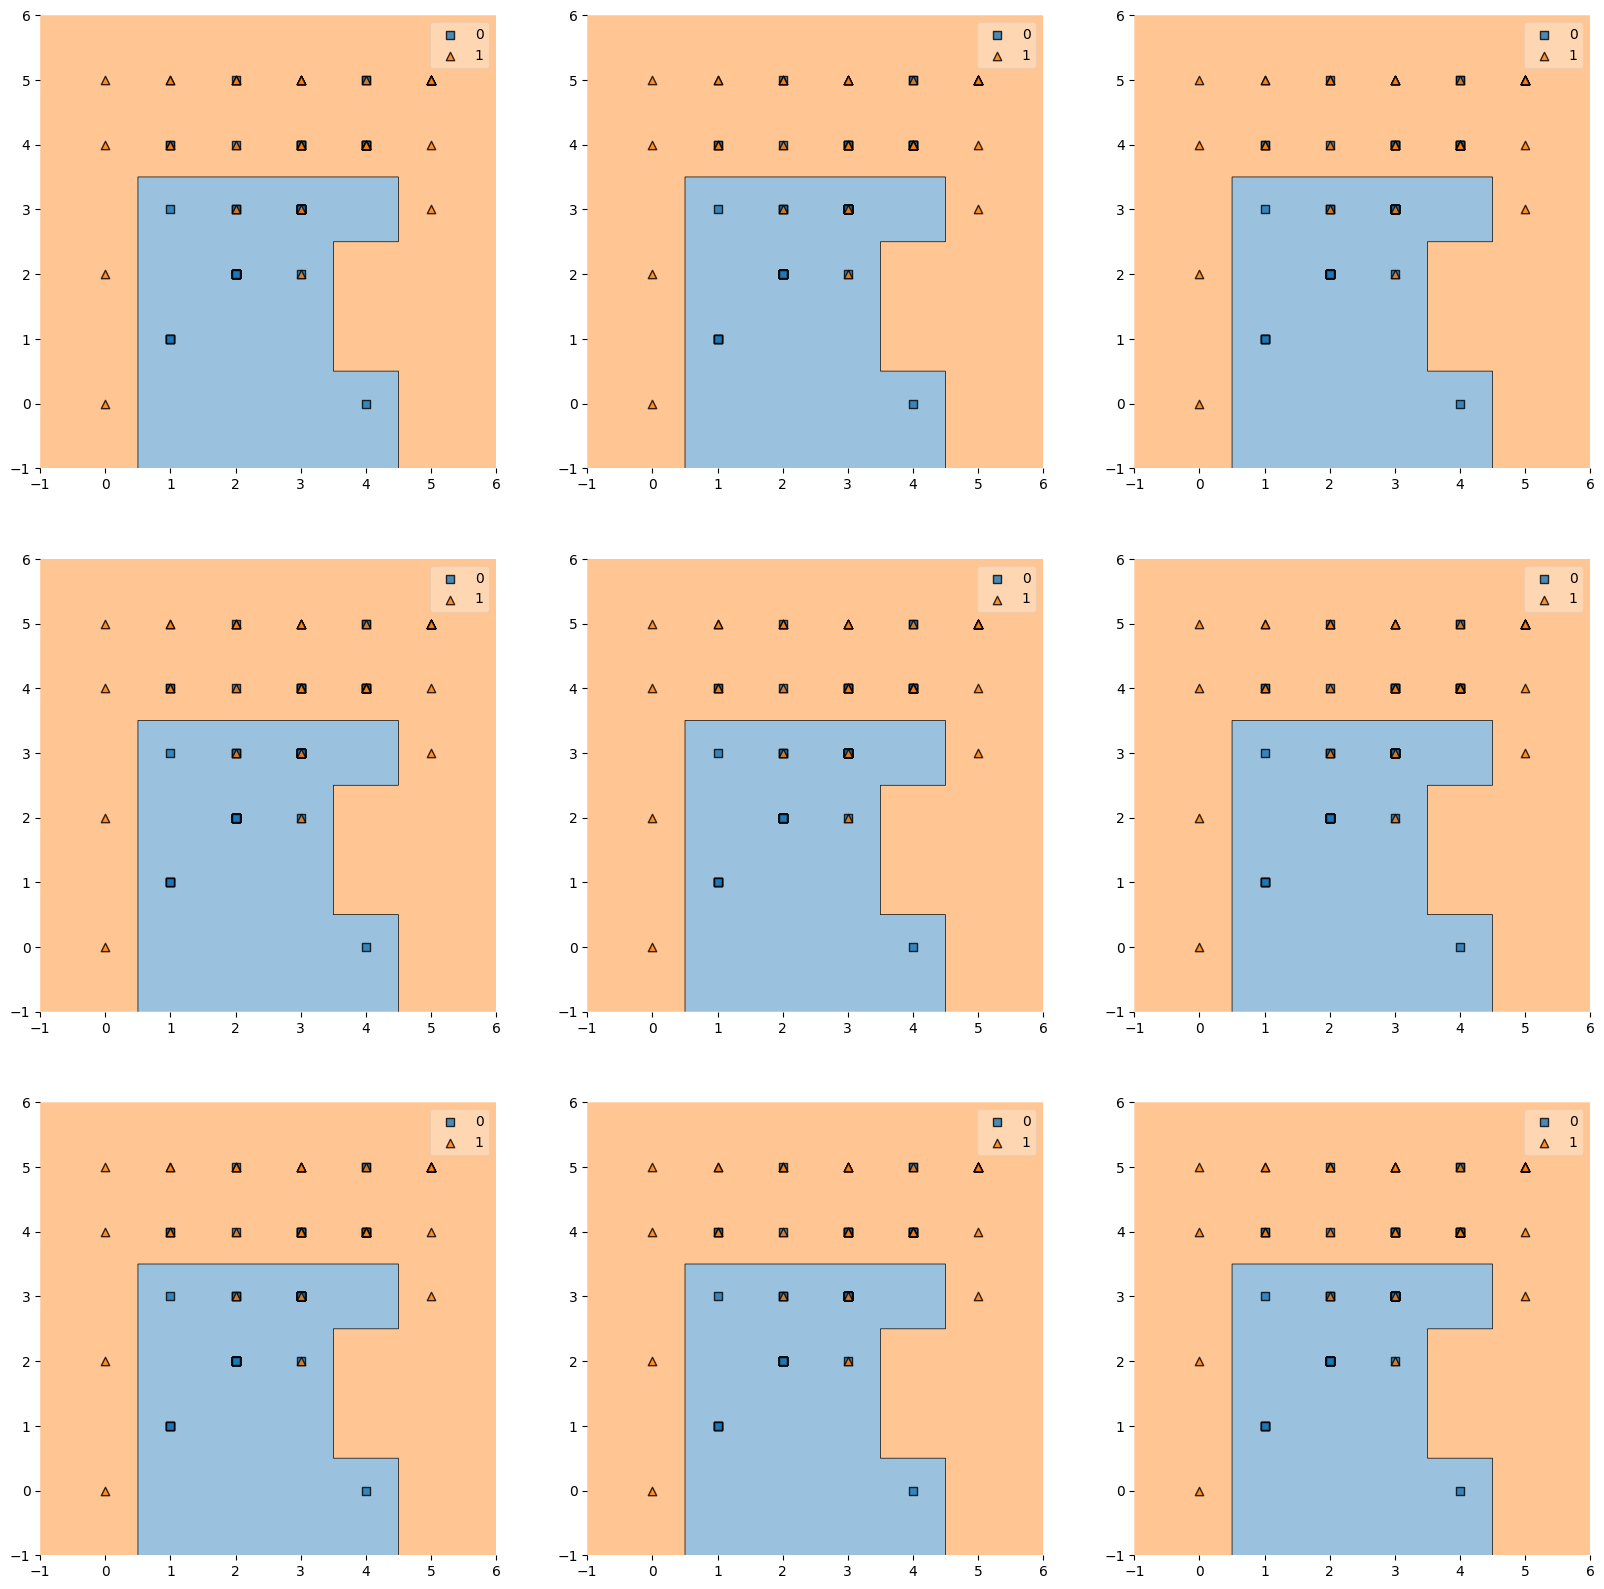

In [52]:
# замените X_train_example на вашу переменную
top_2_features = top_2_features.reset_index(drop=True)

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(top_2_features.index, size=top_2_features.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(top_2_features.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(top_2_features.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 6.57 s, sys: 13 ms, total: 6.58 s
Wall time: 6.7 s


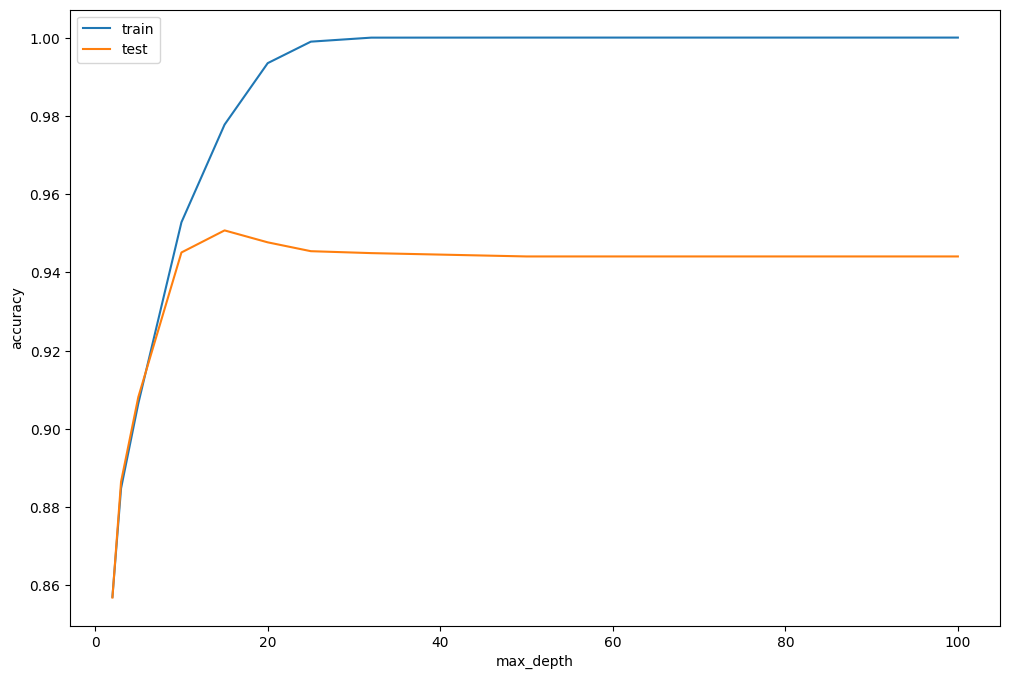

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
params = {
    "max_depth": [3, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"]
}

In [ ]:
tree_2 = DecisionTreeClassifier(random_state=5)
gs = GridSearchCV(tree_2, params, cv=5, scoring="accuracy", n_jobs=-1)
gs.fit(X_train_enc, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
gs.best_params_, gs.best_score_

({'criterion': 'gini',
  'max_depth': 15,
  'min_samples_leaf': 2,
  'min_samples_split': 10},
 0.9503477344573236)

In [ ]:
best_tree = gs.best_estimator_
y_pred = best_tree.predict(X_val_enc)

accuracy = accuracy_score(y_val, y_pred)

In [ ]:
accuracy

0.9509148140861696

Метрика улучшилась с 0.94 до 0.95

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_tree, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train_enc, y_train)
y_pred = forest.predict(X_val_enc)

acc = accuracy_score(y_val, y_pred)
acc

0.9619975080333136

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [ ]:
y_probs = forest.predict_proba(X_val_enc)[:, 1]

In [ ]:
from sklearn.calibration import calibration_curve

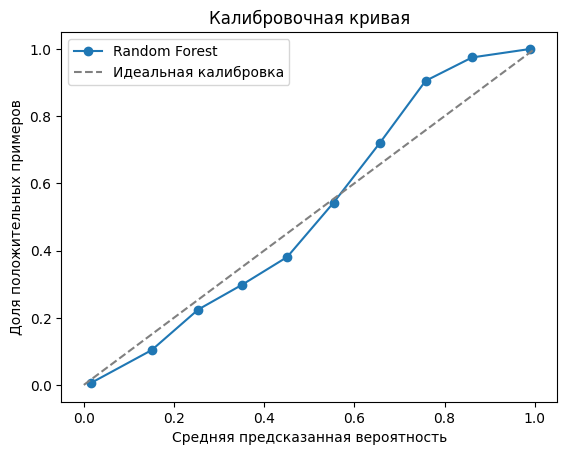

In [ ]:
prob_true, prob_pred = calibration_curve(y_val, y_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o", label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Идеальная калибровка")
plt.xlabel("Средняя предсказанная вероятность")
plt.ylabel("Доля положительных примеров")
plt.title("Калибровочная кривая")
plt.legend()
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

In [ ]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_val, y_probs)
brier_score

0.02912531313528756

In [ ]:
tree_probs = model.predict_proba(X_val_enc)[:, 1]

brier_score = brier_score_loss(y_val, tree_probs)
brier_score

0.05518394648829431


У нас по Brier score получается что деревья хорошо предсказывают вероятности, но на самом деле как деревья так и лес зачастую плохо предсказывают вероятности, тк предсказание делается по доле классов в листьях.




### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train_enc, y_train)
pred_proba = log_reg.predict_proba(X_val_enc)[:, 1]

In [ ]:
pred_log = log_reg.predict(X_val_enc)
acc_log = accuracy_score(y_val, pred_log)
acc_log

0.875762345071808

In [ ]:
log_reg.n_iter_

array([1557], dtype=int32)

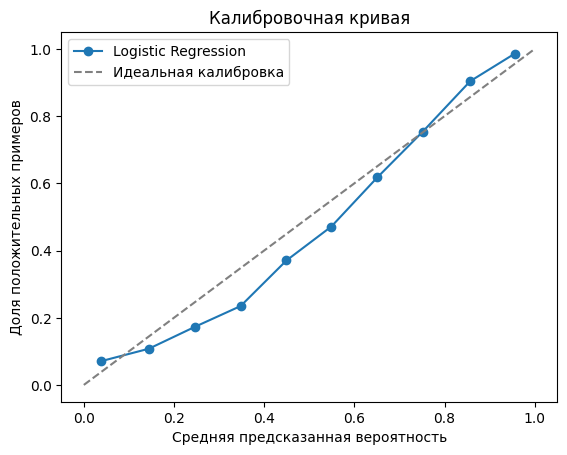

In [ ]:
prob_true, prob_pred = calibration_curve(y_val, pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o", label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Идеальная калибровка")
plt.xlabel("Средняя предсказанная вероятность")
plt.ylabel("Доля положительных примеров")
plt.title("Калибровочная кривая")
plt.legend()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Логистическая регрессия предсказывает вероятности через сигмоидальную функцию, которая симметричная и на выходе дает значения в интервале от 0 до 1, которые интерпретируются как вероятности.

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
log_model = LogisticRegression(max_iter=10000)
log_model.fit(y_probs.reshape(-1, 1), y_val)
prob_forest_log = log_model.predict_proba(y_probs.reshape(-1, 1))[:, 1]

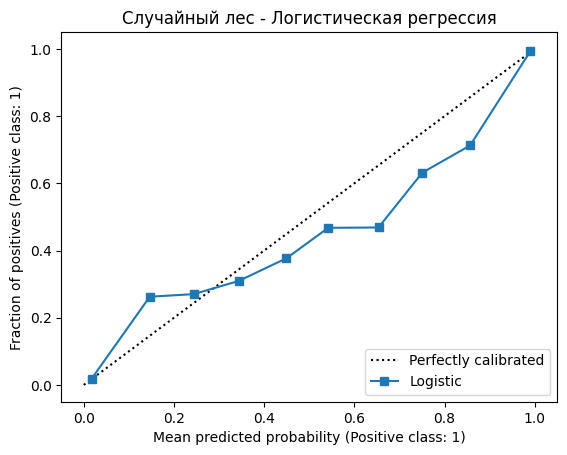

In [ ]:
CalibrationDisplay.from_predictions(y_val, prob_forest_log, n_bins=10, name="Logistic")
plt.title("Случайный лес - Логистическая регрессия")
plt.show()

In [ ]:
iso_model = IsotonicRegression(out_of_bounds="clip")
iso_model.fit(y_probs, y_val)
prob_forest_iso = iso_model.predict(y_probs)

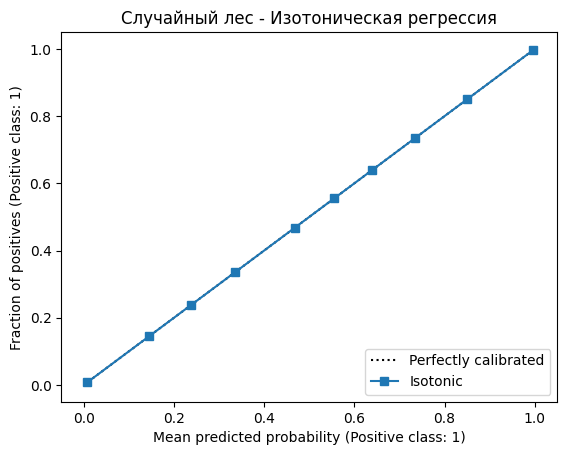

In [ ]:
CalibrationDisplay.from_predictions(y_val, prob_forest_iso, n_bins=10, name="Isotonic")
plt.title("Случайный лес - Изотоническая регрессия")
plt.show()

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

### Гистограммная калибровка:
диапазон вероятностей разбивается на бины, и для каждого бина подсчитывается доля правильных предсказаний и все вероятности внутри бина теперь равны этой найденной общей вероятности  
### Деревья калибровки:  
строится дерево решений для разделения областей калибровки, в каждом листе вычисляется доля правильных предсказаний. Эмпирические вероятности применяются только для нужной области калибровки.

https://alexanderdyakonov.wordpress.com/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(forest, X_train_enc.to_numpy(), y_train, X_val_enc.to_numpy(), y_val,
    loss='0-1_loss', num_rounds=50, random_seed=5)
error_dt, bias_dt, var_dt

(0.03921175159026821, 0.03767460161322054, 0.008601219752114893)

Смещение и разброс дерева продублирую, тк искать сильно далеко:
0.039937045052134565, 0.04356351236146632  
Да изменения есть, смещение почти не изменилось, а вот разброс стал намного меньше, что значит уменьшение вероятности переобучения. Это соответствует реальности, тк лес усредняет результаты нескольких деревьев, что уменьшает разброс.


### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(log_reg, X_train_enc.to_numpy(), y_train, X_val_enc.to_numpy(), y_val,
    loss='0-1_loss', num_rounds=50, random_seed=5)
error_dt, bias_dt, var_dt

(0.1241694537346711, 0.12453275624631123, 0.0041615843661879474)

У логистической регрессии выше смещение и меньше разброс, что указывает на меньшую точность модели(высокое смещение), но меньшую склонность к переобучению(низкий разброс). Тк модель линейная, она может плохо предсказывать нелинейные зависимости, что объясняет высокое смещение по сравнению с лесом.

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
params_forest = {
    'n_estimators': randint(50, 250),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9)
}

forest_search = RandomForestClassifier(random_state=5)
random_search = RandomizedSearchCV(
    forest_search, param_distributions=params_forest,
    n_iter=50, cv=5, scoring='accuracy', random_state=5, n_jobs=-1
)

random_search.fit(X_train_enc, y_train)

best_forest = random_search.best_estimator_
y_pred_forest = best_forest.predict(X_val_enc)
accuracy_forest = accuracy_score(y_val, y_pred_forest)
best_forest, accuracy_forest

(RandomForestClassifier(max_depth=19, max_features=0.37830769432612954,
                        min_samples_leaf=3, min_samples_split=8,
                        n_estimators=192, random_state=5),
 0.9626860777755919)

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

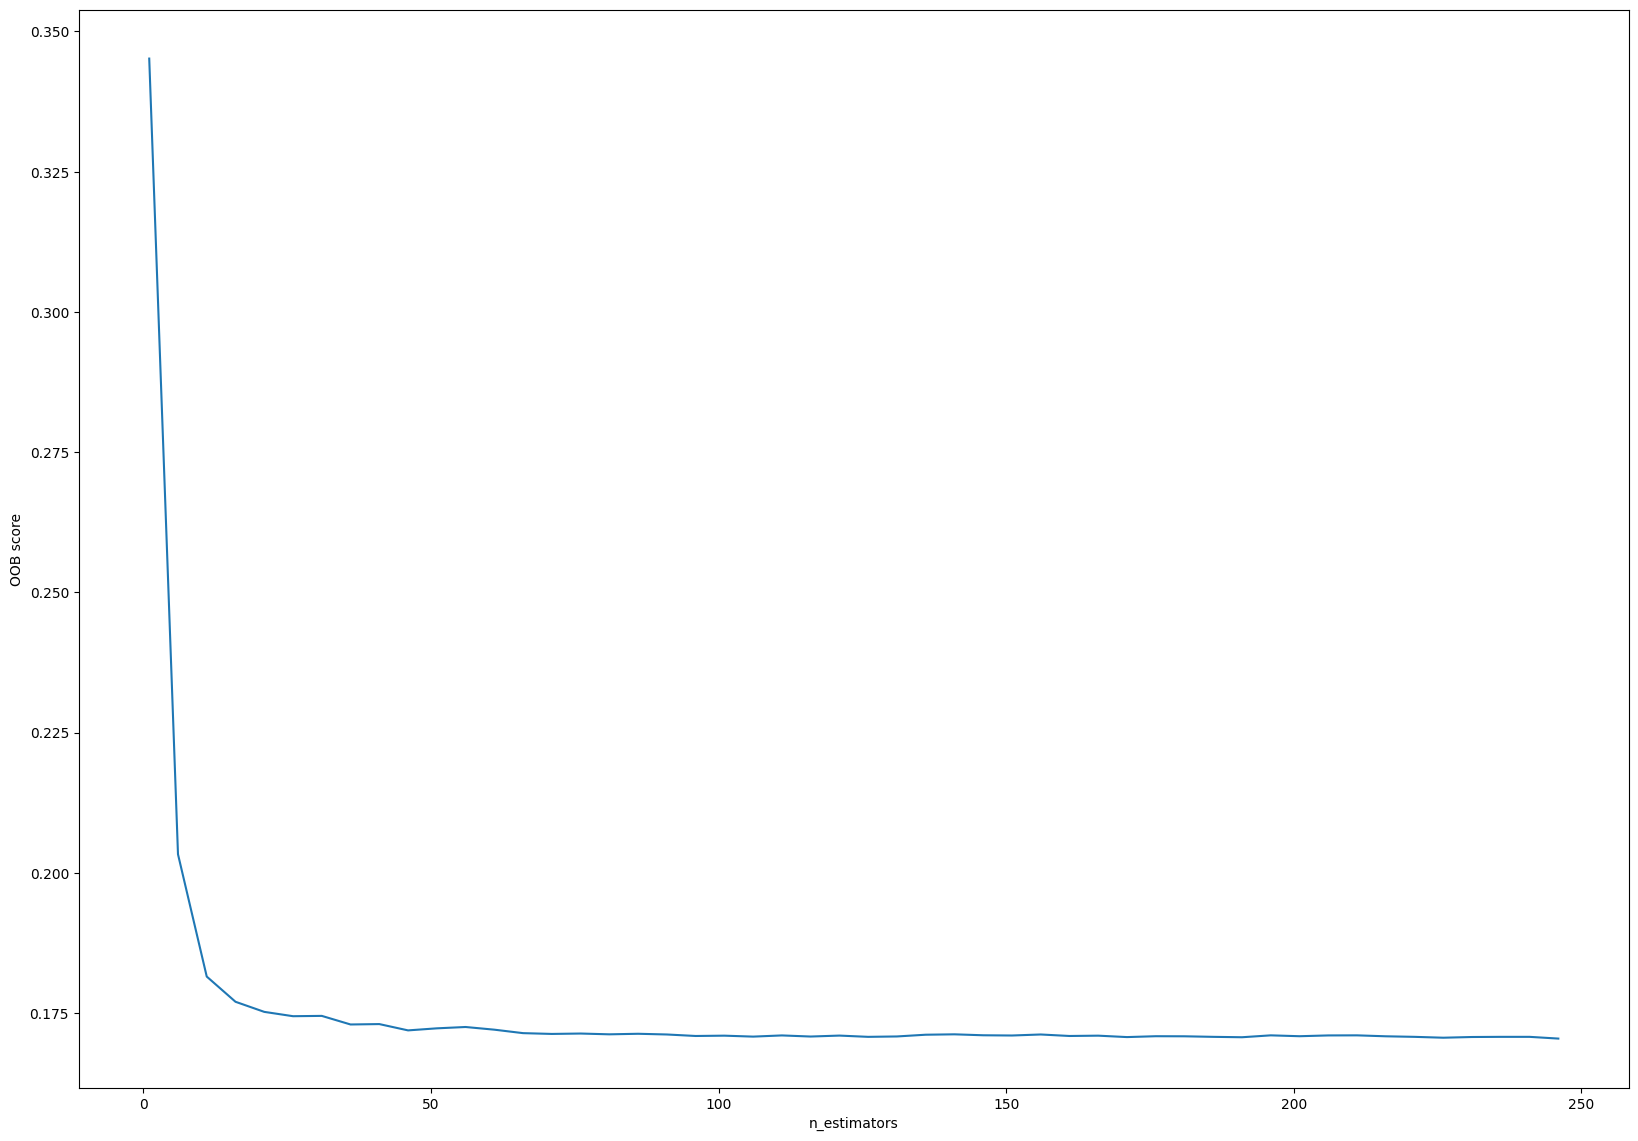

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
best_forest.feature_importances_

array([0.01881688, 0.01486704, 0.00484505, 0.0069789 , 0.16103639,
       0.00781173, 0.0314022 , 0.01079028, 0.00454962, 0.24083748,
       0.03324375, 0.05836442, 0.0190723 , 0.02002381, 0.01876273,
       0.02194647, 0.01938407, 0.01713633, 0.00119573, 0.00124647,
       0.02497359, 0.0227278 , 0.0581358 , 0.06863456, 0.08909082,
       0.0232665 , 0.00085929])

In [34]:
with open('BestForest.pkl', 'rb') as f:
  best_forest = pickle.load(f)

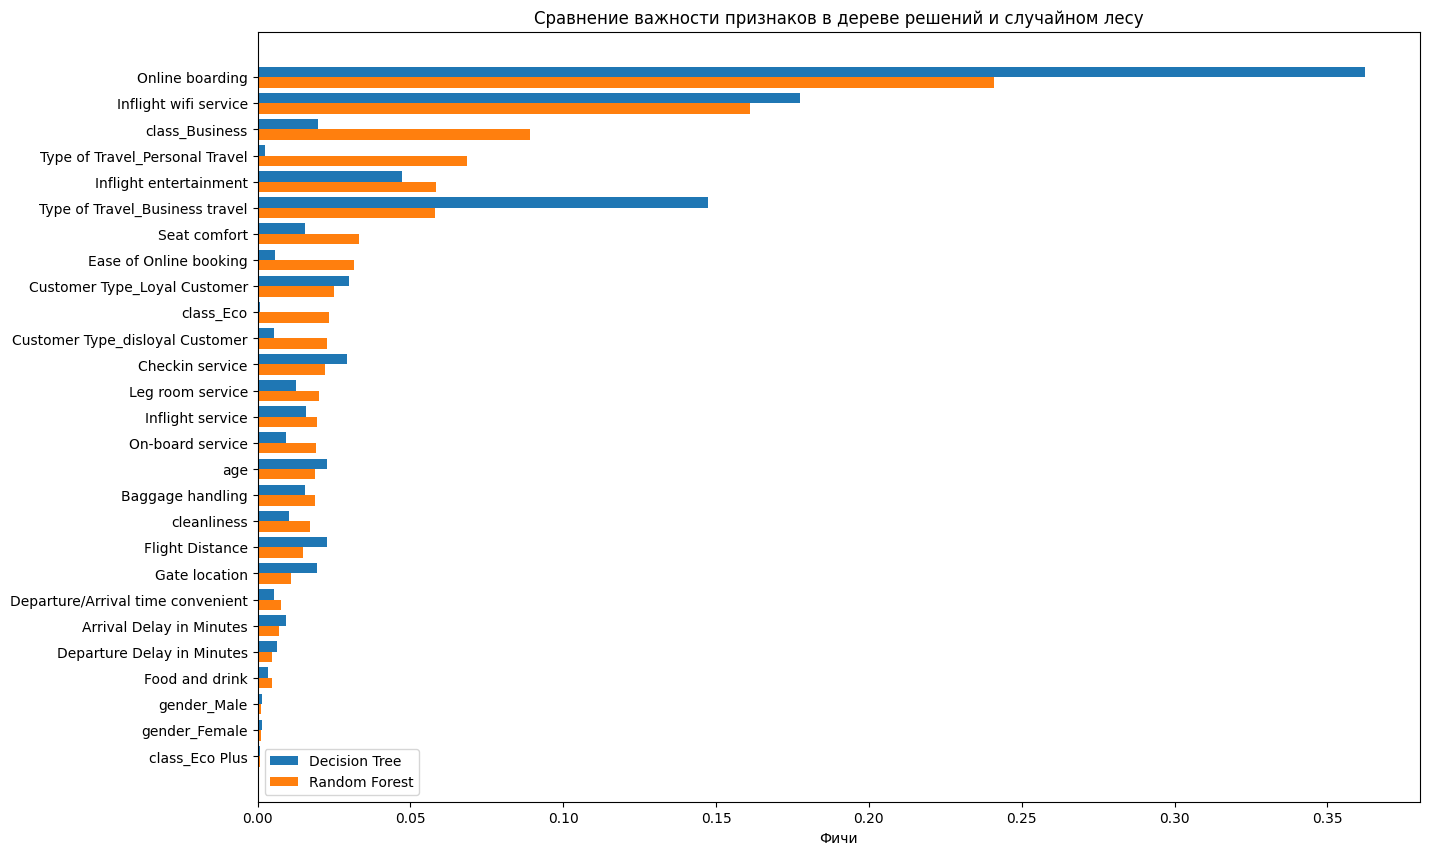

In [39]:
feature_impotant_forest = best_forest.feature_importances_
features = X_train_enc.columns

df_importances = pd.DataFrame({
    "Feature": features,
    "Decision Tree": feature_impotant_tree,
    "Random Forest": feature_impotant_forest
}).sort_values(by="Random Forest", ascending=False)

bar_width = 0.4
x = np.arange(len(features))

plt.figure(figsize=(15, 10))
plt.barh(x - bar_width/2, df_importances["Decision Tree"], height=bar_width, label="Decision Tree")
plt.barh(x + bar_width/2, df_importances["Random Forest"], height=bar_width, label="Random Forest")

plt.yticks(x, df_importances["Feature"])
plt.xlabel("Фичи")
plt.title("Сравнение важности признаков в дереве решений и случайном лесу")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

Первый 2 признака по важности у дерева и нашего леса совпали, а вот третий у дерева был тип поездки - бизнес, а у леса класс - бизнес

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [ ]:
with open('BestForest.pkl', 'wb') as f:
    pickle.dump(best_forest, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [41]:
X_train_1000 = X_train_enc.sample(n=1000, random_state=5)

In [60]:
explainer = shap.TreeExplainer(best_forest, X_train_1000)
shap_values = explainer.shap_values(X_train_1000)

if isinstance(shap_values, list):
    shap_values_1 = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_values_1 = shap_values

shap_importances = np.abs(shap_values_1).mean(axis=0)

100%|===================| 1991/2000 [04:28<00:01]       

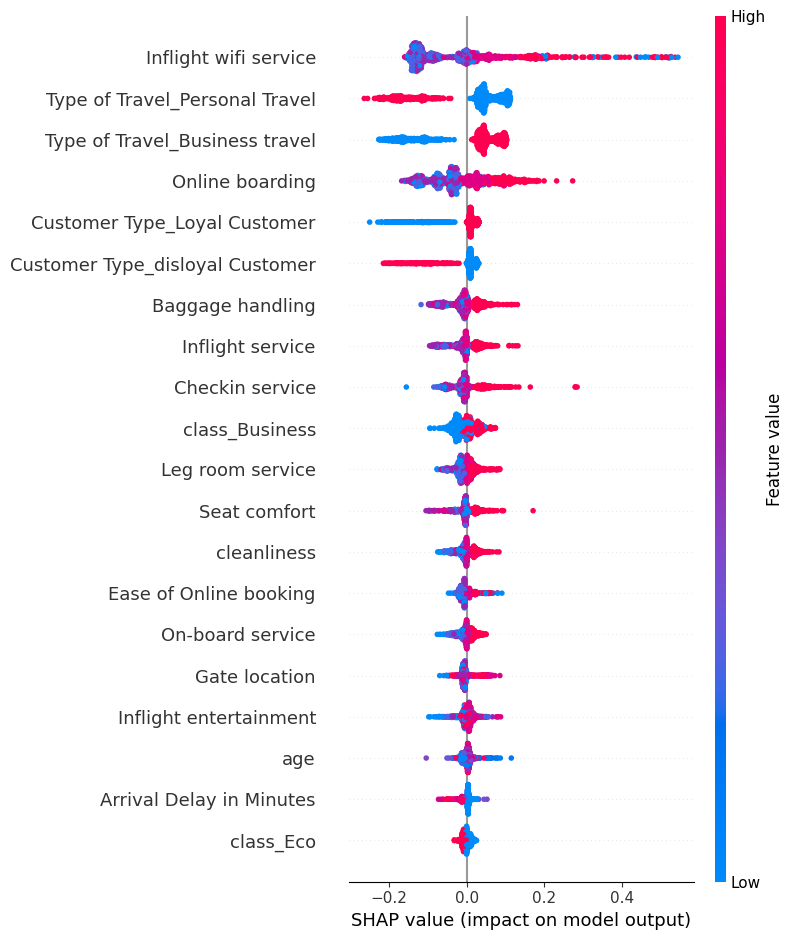

In [64]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_1[:, :, 1], X_train_1000)

In [61]:
X_train_1000.columns.shape, shap_importances.shape, shap_values_1.shape

((27,), (27, 2), (1000, 27, 2))

Высокие оценки по wi-fi на борту и онлайн посадочный увеличивают вероятность того, что модель предскажет положительных класс(удовлетворен), а более низкие оценки наоборот уменьшают этот шанс.  
Тип поездки тоже влияет, персональная поездка отрицательно влияет на предсказание, бизнес же положительно    
Неожиданно, но задержка прибытия почти не влияет на предсказание класса.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

1. Помимо summary_plot, который я использовала, в шап есть Dependence plot который показывает взаимодействие между признаками, Force Plot показывающий как каждый признак влияет на конкретное предсказание(положительное и отрицательное), Decision Plot - показывает процесс как модель пришла к окончательному ответу.
2. Кроме TreeExplainer алгоритма, настроенного для деревьев и их ансамблей, есть DeepExplainer - для нейронок, LinearExplainer - для линейных моделей, KernelExplainer - более общий, подходит для всех моделей.
3. Также в документации есть примеры использования для табличных данных, для картинок, текстов, геномных данных.

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [68]:
from lime.lime_tabular import LimeTabularExplainer

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


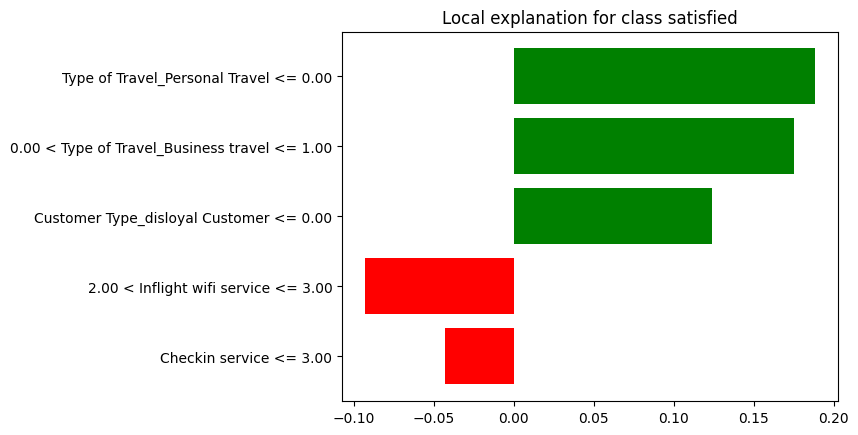

In [78]:
explainer = LimeTabularExplainer(
    training_data=X_train_enc.values,
    training_labels=y_train,
    feature_names=X_train_enc.columns,
    class_names=["neutral or dissatisfied", "satisfied"],
    mode="classification"
)
sample_index = 0
sample = X_val_enc.iloc[sample_index].values.reshape(1, -1)
# sample = sample.values

explanation = explainer.explain_instance(
    data_row=sample.flatten(),
    predict_fn=best_forest.predict_proba,
    num_features=5
)

explanation.as_pyplot_figure()
plt.show()

Тип поездки бизнес и участники лояльной программы(не нелояльные) увеличивают шанс положительного класса. Оценка wi-fi от 2 до 3 и оценка сервиса регистрации меньше 3 снижают предсказания положительного.

## Котобонус!

0.25 балла

Скорее всего кот Елены

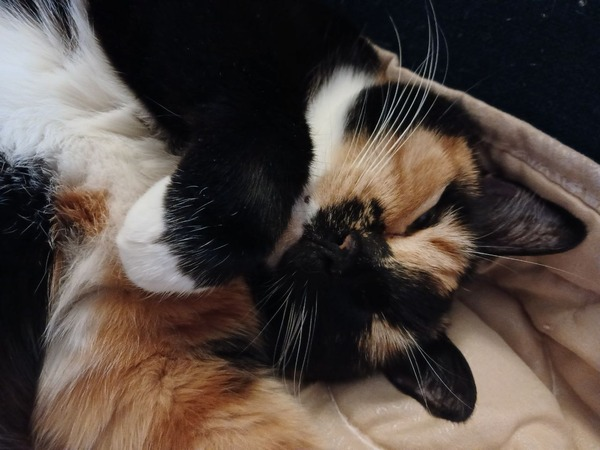

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Я думаю, домашнее задание очень полезное, много практики, на которой начинаешь понимать материал данный на лекциях. По сложности поставлю 8, главная сложность в объеме, на каждое дз по мл у меня уходит от 3-4 дней. Очень порадовали теоретические вставки и ссылки на статьи. А еще очень люблю котиков )